# Error of the estimated mean for time-series data


A common analysis task is determining the mean	value of a metric in a population - here we consider the metric to be the arithmetic mean. Because we don't have access to the entire population, this is almost always done by taking some sample data from the broader population, measuring the mean in the sample, then taking that measurement as an estimation of the true value (hence 'estimator'). Because the estimator doesn't return the exact true value, it should be accompanied by error bars. For sample data that is independent, calculating the standard error of the estimated mean is trivial using a formula. Some other data, for example time series, are highly correlated and thus need some adjustments to determine the error. 

Despite the broad range of fields that measure time series data - ecology, econometrics, physical simulations, astronomy, etc... - there's no single, accepted approach to calculating the standard error of the mean, motiviating this article.  


This article demonstrates four different techniques for determing the standard error of the estimated mean:
- Block averaging
- Using a correction factor
- Autoregressive (AR(1)) maximum likelihood fit
- Autoregressive (AR(1)) bayesian fit


------------

First, to demonstrate the problem, below shows examples of independent data (top panel) and highly correlated data time series data (bottom panel):


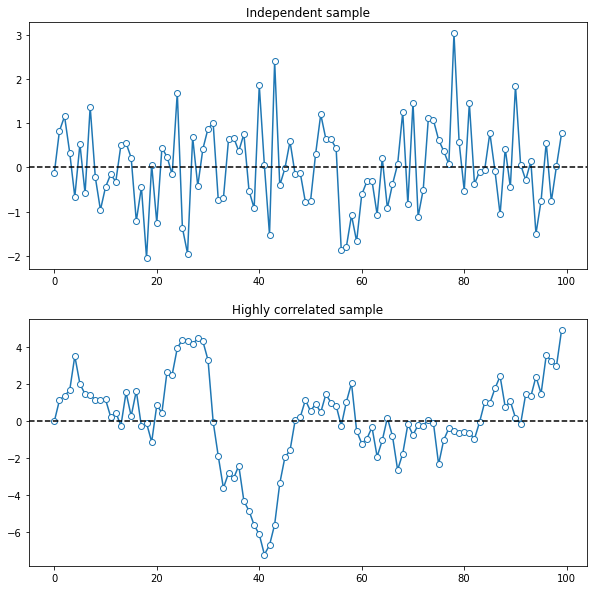

In [1]:
import matplotlib.pyplot as plt
import numpy as np
#np.random.seed(2572367)
np.random.seed(257367)


def gen_correlated_curve(ac, num=100, innovation=1):
    y = np.zeros((num,))
    for i in range(1,num):
        y[i] = ac * y[i-1] + np.random.normal()*innovation
    return y

uncorrelated = np.random.randn(100)
correlated = gen_correlated_curve(0.90)

fig, ax = plt.subplots(ncols=1, nrows=2); fig.set_figheight(10); fig.set_figwidth(10)
ax[0].plot(uncorrelated, '-o', mfc='white'); ax[0].set_title('Independent sample'); ax[0].axhline(0, c='k', linestyle='--')
ax[1].plot(correlated, '-o', mfc='white'); ax[1].set_title('Highly correlated sample'); ax[1].axhline(0, c='k', linestyle='--')


The key difference is that in the case of highly correlated data, each new point is very similar to the previous one. This is known as autocorrelation. For independent data this is not the case - each new point has no memory of the previous points even though all points are still centred on a common mean value. 

This causes difficulty when calculating error bars. Normally, for independent data, when estimating the mean value you would calculate the standard error of that estimate using:

\begin{align}
SEM = \frac{s}{\sqrt{n}}
\end{align}

which in english says "the standard error of the (estimated) mean, called $SEM$, is equal to the standard deviation ($s$) of the sample divided by the square root of the number of samples". The formula isn't so special, it can be found on the wikipedia entry for [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error). 

The problem with using this formula for highly correlated data is the $\sqrt{n}$ in the denominator - it can become very large for time series data, especially if you take samples at high frequency. Consider an example: measure your body temperature every hour for four weeks. It fluctuates over the day/night cycle, but doesn't change too much hour by hour. In that case, $n=672$. Now imagine measuring it every minute for a month, so $n=40320$. The $n$ has multiplied by $60$, meaning the $SEM$ becomes smaller by $\sqrt{60}$. Yet in both cases you sampled for the same total time. Your actual body temperature would have varied by about the same amount, meaning you would expect the error bars to be about the same.


Put another way, high frequency sampling of a time-varying process gives you lots of unnecessary data points because each point is similar to its neighbours, and this makes the sample look very precise when it isn't. 



# Autocorrelation

This correlation between adjacent points can be visualized using an `autocorrelation plot`. Autocorrelation plots range from `-1 to 1` and measure how correlated adjacent points are, with `1` being total positive correlation, `0` being no correlation at all, and `-1` being total negative correlation. Autocorrelation plots measure how correlated a sample is to another point at some time lag. When the time lag is zero, autocorrelation must be `1` because each point must be completely positively correlated with itself! 

The below shows an example of three time series with different levels of positive correlation. When the autocorrelation plot reaches zero, it's safe to assume that the time lag is big enough that any data point has no memory of another data point separated by that lag. This value of the time lag is characteristic to an autocorrelated process, and is called the 'autocorrelation time' ($\tau$, tau). In practice, there's a lot of noise around the autocorrelation of zero which appears even using independent data. 

`??? See Detecting Signals from Data with Noise: Theory and Applications` for significance testing of autocorrelation vs. white noise 


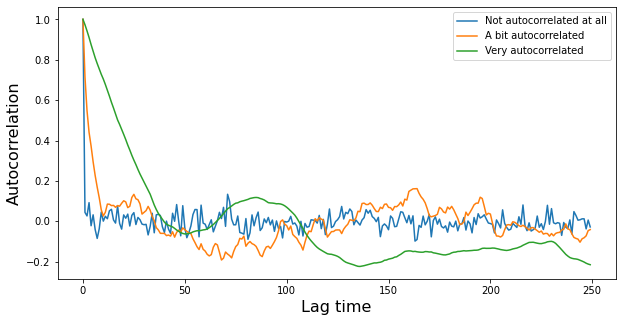

In [2]:
plt.figure(figsize=(10, 5))
for ac, label in zip([0, 0.8, 0.99], ['Not autocorrelated at all', 'A bit autocorrelated', 'Very autocorrelated']):
    curve = gen_correlated_curve(ac, num=500)
    #calculate autocorrelation:
    co = np.correlate(curve-curve.mean(),curve-curve.mean(), mode='same')
    co = co/co.max()
    co = co[int(co.shape[0]/2):]
    
    plt.plot(co,label=label)

plt.legend()
plt.xlabel('Lag time', fontsize=16)
_=plt.ylabel('Autocorrelation', fontsize=16)


# Approach 1: Block averaging
'Undoing' the autocorrelation allows us to calculate $SEM$ as if the sample was independent. One way to do this is block averaging. First, a baseline value for the $SEM$ is calculated using all points. To do one round of block averaging, every second point and it's adjacent point forward in time are averaged, creating 'blocks' of size 2 and resulting in a dataset with $ \frac{n}{2} $ points. 

Here's an example:

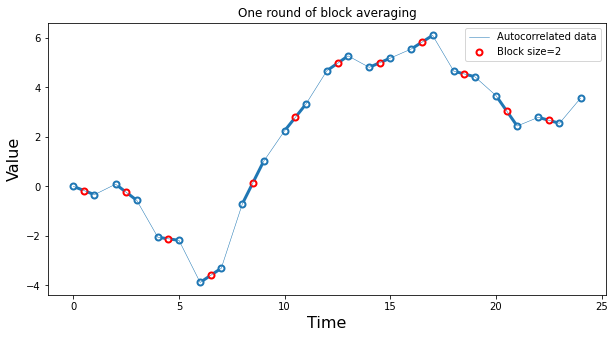

In [3]:

correlated = gen_correlated_curve(0.99, num=25)
x = np.arange(len(correlated))

plt.figure(figsize=(10,5))
plt.title('One round of block averaging')
plt.plot(x,correlated,mew=1, linewidth=0.5, label='Autocorrelated data')

#plot pairs:
for i in range(0,13):
    plt.plot(x[i*2:i*2+2],correlated[i*2:i*2+2],'-o', c='C0', mfc='white', mew=2, linewidth=3, zorder=0)

#do one round of block averaging, blocksize of 2
x_ = x[:len(x)-(len(x)%2)].reshape(-1,2).mean(1)
y_ = correlated[:len(x)-(len(x)%2)].reshape(-1,2).mean(1)

plt.scatter(x_, y_, facecolor='white', edgecolor='red', linewidth=2,zorder=2, label='Block size=2')
plt.xlabel('Time',fontsize=16)
plt.ylabel('Value',fontsize=16)
_=plt.legend()

By increasing the size of the blocks from 2,3,4..., the hope is that eventually adjacent blocks are far enough apart in time that they are totally uncorrelated and the data resemble an independent sample. This occurs when the blocks are bigger than the autocorrelation time $\tau$. It appears as an asymptote in the $SEM$, and would also correspond to reaching zero in the autocorrelation plot. 

To demonstrate, the below shows blocks up to `size=200` using 5000 points from an autocorrelated time series: 

In [4]:
from scipy.stats import sem

def do_block_averaging(corr):
    sems = list()
    x=np.arange(len(corr))
    #for blocksize in range(1, int(len(corr)//25)+1):
    for blocksize in range(1, int(len(corr)**(2/3))+1):
        #this is the blocking bit:
        x_ = x[:len(x)-(len(x)%blocksize)].reshape(-1,blocksize).mean(1)
        y_ = corr[:len(x)-(len(x)%blocksize)].reshape(-1,blocksize).mean(1)
        sems.append(sem(y_))
    return sems

        
correlated = gen_correlated_curve(0.6, num=5000)
x = np.arange(correlated.shape[0])

blocked_sems = do_block_averaging(correlated)

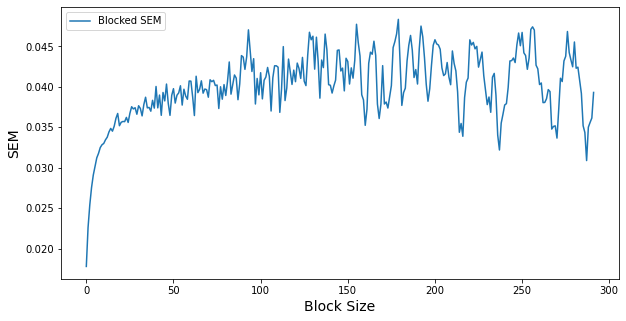

In [5]:
#plot:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot(blocked_sems, label='Blocked SEM')
ax.set_xlabel('Block Size', fontsize=14)
ax.set_ylabel('SEM',fontsize=14)
_=ax.legend()

There are a few problems with this approach:

- **Wasting data**. In order to maintain identically distributed blocks, each block should be exactly the same size. So, what if the block size doesn't evenly divide the total number of measurements? The overhanging data has to be discarded, which is a waste of perfectly good measurements
- **Noise** - as seen above, the $SEM$ values become noisy after the asymptote is reached, rather than converging towards the true value. This is a consequence of cutting data - as the block size grows, larger and larger overhanging chunks get removed until the blocksize is an even divisor of the number of samples. The changes in the amount of data being used leads to jumps in the calculated $SEM$.
- **Arbitrary choice of asymptote**. By eye it seems pretty obvious what region the $SEM$ lies in, but how do you choose a consensus value? One way to remedy this is to automate the choice by fitting some curve that also grows to an asymptote like the $SEM$. There doesn't appear to be a known curve to use for the fit, but curves based on `y=arctan(x)` work. However, on the edge cases where the optimum block size is only 2 or 3, or it's nearly as many samples as you have, the fit can be (wildly) inaccurate.


Because we have a good smooth curve above, the below demonstrates fitting the curve `y= a*arctan(b*(x-c))` to find the asymptote of the $SEM$.


In [6]:
# fitting to arctan
from scipy import optimize

def block_avg_fit(x, a, b, c):
    return a * np.arctan(b*(x-c))

popt, pcov = optimize.curve_fit(block_avg_fit, np.arange(len(blocked_sems)), np.array(blocked_sems))


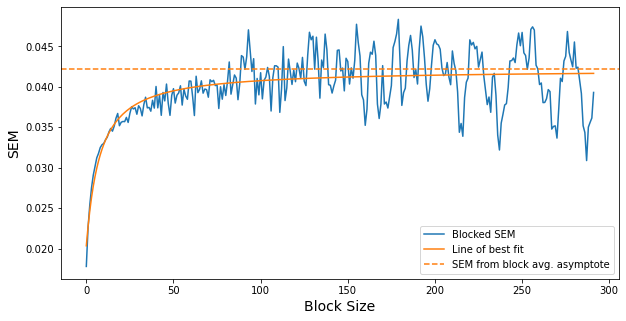

In [7]:
#plot:
ax.plot(np.arange(len(blocked_sems)),
        block_avg_fit(np.arange(len(blocked_sems)), popt[0], popt[1],popt[2]), 
        label='Line of best fit')
ax.axhline(popt[0] *np.pi/2, label='SEM from block avg. asymptote', linestyle='--', c='C1')
ax.legend()
fig

So block bootstrapping works well if you have lots of data and a smooth curve. But what to do in other cases? Below demonstrates some alternatives that use all the available data and give definite answers without requiring a good block averaging plot.

# Approach 2: Estimating $n_{eff}$ from the autocorrelation function

Block averaging works by reducing the number of data points $n$ until the $SEM$ converges. At this point, we expect adjacent points to look independent. The value of $n$ that achieves this is known as the 'effective $n$', or $n_{eff}$, and it reflects how many independently sampled data points you actually have in the sample. There are other ways to calculate $n_{eff}$ that are more direct than block averaging, and interestingly they can result in fractional values.  

Adjusting the wikipedia equation for $SEM$, we now have:

\begin{align}
SEM = \frac{s}{\sqrt{n_{eff}}}
\end{align}

Calculating $n_{eff}$ normally happens by first calculating the autocorrelation time $\tau$. The autocorrelation time is the time it takes for the process to forget a past value - meaning  the autocorrelation plot should be close to zero. This time, of course, doesn't need to be an integer value, which is how $n_{eff}$ can be fractional. 

\begin{align}
n_{eff} = \frac{n}{\tau}
\end{align}

So how to find $\tau$? The two techniques given below, called here Sokal and Chodera (see refs below), estimate $\tau$ from the autocorrelation function and have reasonable agreement with block averaging if you sampled for many multiples of $\tau$.



>Chodera: see https://github.com/choderalab/pymbar for code, and `Use of the Weighted Histogram Analysis Method for the Analysis of Simulated and Parallel TemperingSimulations`
>
>Sokal: see https://dfm.io/posts/autocorr/ for code, [here](https://pdfs.semanticscholar.org/0bfe/9e3db30605fe2d4d26e1a288a5e2997e7225.pdf) for Sokal notes


In [8]:
import statsmodels.api as sm
def next_pow_two(n):
    #lew: complicated one-liner: int(2**(np.ceil(np.log2(number))))
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x):
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n 
    acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def sokal_autocorr_time(corr):
    f = autocorr_func_1d(corr)
    taus = 2.0*np.cumsum(f)-1.0
    c=5
    window = auto_window(taus, c)
    return taus[window]

def statineff(corr, mintime=3):
    N = corr.size
    C_t = sm.tsa.stattools.acf(corr, fft=True, unbiased=True, nlags=N)
    t_grid = np.arange(N).astype('float')
    g_t = 2.0 * C_t * (1.0 - t_grid / float(N))
    ind = np.where((C_t <= 0) & (t_grid > mintime))[0][0]
    g = 1.0 + g_t[1:ind].sum()
    return max(1.0, g)


#chodera:
chodera_autoc_time = statineff(correlated)

#sokal:
sokal_autoc_time = sokal_autocorr_time(correlated)

n=len(correlated)
chodera_sem = np.std(correlated) / np.sqrt(n/chodera_autoc_time)
sokal_sem = np.std(correlated) / np.sqrt(n/sokal_autoc_time)

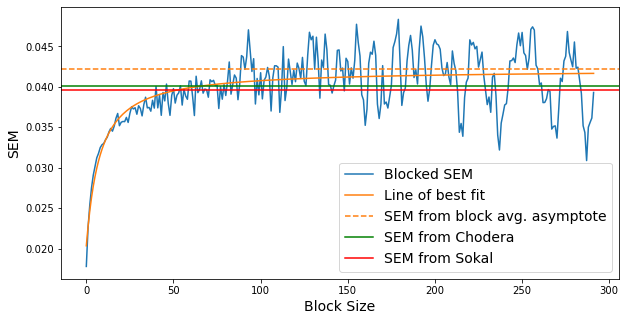

In [9]:
#plot:
ax.axhline(chodera_sem, label='SEM from Chodera', c='green')
ax.axhline(sokal_sem, label='SEM from Sokal', c='red')
ax.legend(fontsize=14)
fig

# Approach 3: Autoregressive processes
A third way to estimate the $SEM$ is by treating it as an autoregressive process. Here, it helps to understand what it is that makes time series correlated with themselves. The simplest model of autocorrelation is called an `autoregressive model` where we only consider the time lag at lag=1, commonly just called `AR(1)`. [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_model) has some more details on these, but here's the short version. In an AR(1) process, each new point is equal to the previous point multiplied by a number $\rho$ (rho), plus or minus some white noise (i.e. random noise).

In maths, using $X_t$ to mean 'point $X$ at time $t$' and $\epsilon$ (epsilon) to mean 'random noise':

\begin{align}
X_t = \rho X_{t-1} + \epsilon
\end{align}

When $\rho$ is less than 1, each step pulls the point back towards zero (hence auto*regressive*), meaning the time series will maintain a mean of zero. Moving average models are also commonly used, but a stationary mean makes things a bit easier. If your time series isn't centred on zero, the AR(1) model can just add a constant that shifts the whole sample back to zero, and then still use the model above. 

First, let's estimate the $\rho$ parameter. This can be done using linear regression, where you calculate the slope of the line that goes between any point and its adjacent neighbour. Remember, the true $\rho$ in this case was 0.6.


In [10]:
from statsmodels.tsa.ar_model import AutoReg

#find estimated rho using ordinary least squares
result = AutoReg(correlated-correlated.mean(), lags = [1]).fit()
estimated_rho = result.params[1]
print('###################################')
print(f'Estimated rho is {estimated_rho}, with 95% CI of {result.conf_int()[1]}')
print('###################################')

###################################
Estimated rho is 0.6111243087797814, with 95% CI of [0.58917639 0.63307223]
###################################


Not a bad estimate for $\rho$. Next, we can use a handy formula, which is a consequence of assuming an autoregressive AR(1) process, to get an estimate for the $SEM$. First the $SEM$ gets calculated naively, giving the wrong answer. Then it's multiplied by a correction factor $k$, which is:

\begin{align}
k = \sqrt{\frac{1+\rho}{1-\rho}}
\end{align}

So now we have:

\begin{align}
SEM = \frac{ks}{\sqrt{n}}
\end{align}

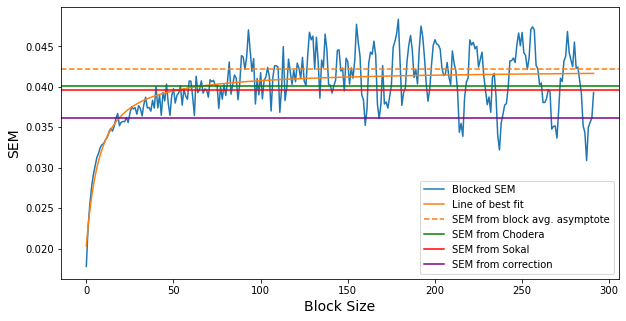

In [11]:
correction = np.sqrt((1+estimated_rho)/(1-estimated_rho))

naive_sem = sem(correlated)
corrected_sem = naive_sem*correction

ax.axhline(corrected_sem, label='SEM from correction', c='purple')
ax.legend()
fig

Before moving on, it's also neat to see how big this correction factor can get. At $\rho$ close to 0, i.e. less than about 0.2, $k$ is barely greater than 1, meaning the naive $SEM$ doesn't change much. But as $\rho$ approaches 1, the $k$ can grow very large. Because you might be multiplying small numbers by big numbers here, you would probably need very large sample sizes to get precise estimates if the process is highly autocorrelated.  

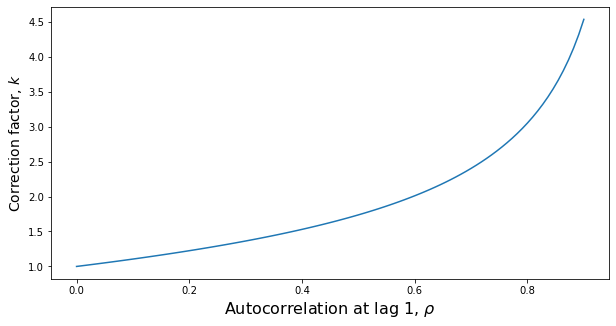

In [18]:
def correction_factor(rho, n):
    d = ((n-1)*rho - n*rho**2 + rho**(n+1)) / (1-rho)**2
    k = np.sqrt( (1 + (2*d)/n) / ( 1 - (2*d)/(n*(n-1))  ) )
    return k

x = np.linspace(0,0.9,100)
plt.figure(figsize=(10,5))
plt.ylabel('Correction factor, $k$',fontsize=14); plt.xlabel('Autocorrelation at lag 1, $\\rho$',fontsize=16)
_ = plt.plot(x, correction_factor(x, 100))


So, to take stock: 
Block averaging clumps the data together in order to reduce $n$, but doesn't make use of all data. Other approaches estimate $n_{eff}$ from the autocorrelation plot. Alternatively you can assume an AR(1) process, fit with ordinary least squares to find $\rho$, then use a correction factor to fix the naively-calculated $SEM$.


The final technique here also uses an AR(1) model, but instead of using a correction equation, it simulates how probable a range of different mean values are,then reports the region of highest probability.


# Approach 4: AR(1) via Bayesian estimation
The above approaches report what is known as the `maximum likelihood` estimate of the $SEM$. It's called maximum likelihood simply because it's the single most likely value after you factor in any model assumptions that were made (like the AR(1) assumption, or normally-distributed noise). 

An alternative is Bayesian estimation. There are, of course, still model assumptions - this still uses an AR(1) model. The trick here is that we try and find the $\rho$ parameter by also estimating where the mean value is. Afterwards, we can throw away the $\rho$ estimate and just look at the most probable values for the mean. These most probable values are encompassed in a 'highest posterior density' which can be directly interpreted as a probability (unlike confidence intervals). 

The below demonstrates a Bayesian fit of an AR(1) model, using the `PyMC3` library, which jointly estimates the value of the mean and the $\rho$, and can then report a full spectrum of likely values for the mean (or for $\rho$ if you want). The 95% highest posterior density is used instead of the $SEM$.

In [13]:
import pymc3 as pm
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)


def do_bayes_sem(corr):
    with pm.Model() as ar1:
        k_ = pm.Uniform('k',-1,1) #we assume process is stationary, so -1<k_<1 
        tau_ = pm.Gamma('tau',mu=1,sd=1)
        center = pm.Normal('center', mu=corr.mean(), sigma=5) #set the prior for the mean to be centred onthe population mean
        likelihood = pm.AR1('likelihood', k=k_, tau_e=tau_, observed=corr-center)
        trace = pm.sample()
    return trace
#slower:
#     with pm.Model() as ar1:
#         rho = pm.Uniform('rho', -1,1)
#         center = pm.Normal('center', mu=corr.mean(), sigma=5)
#         likelihood = pm.AR('likelihood', rho, sigma=1.0, observed=corr-center)
#         trace = pm.sample(500, chains=1, progressbar=True)
#     return trace

trace = do_bayes_sem(correlated)


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1488.18draws/s]


In [24]:
import pymc3 as pm
with pm.Model() as ar1:
    k_ = pm.Uniform('k',-1,1) #we assume process is stationary, so -1<k_<1 
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=correlated.mean(), sigma=5) #set the prior for the mean to be centred onthe population mean
    likelihood = pm.AR1('likelihood', k=k_, tau_e=tau_, observed=correlated-center)
    
    
with ar1:
    trace = pm.sample()

kdeplot(trace['center'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, k]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 917.89draws/s] 


NameError: name 'kdeplot' is not defined

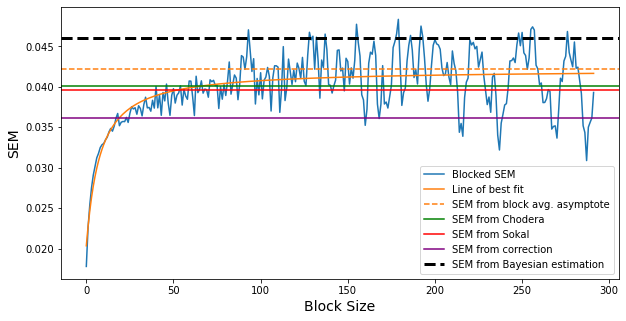

In [14]:
hpd = pm.stats.hpd(trace['center'])
hpd_sem = (hpd[1]-hpd[0]/2)/1.96

ax.axhline(hpd_sem, c='black', linestyle='--', linewidth=3,
            label='SEM from Bayesian estimation')

ax.legend()
fig



There's a lot more analysis one might do with the results here. As a taste, you can plot the posterior density of the mean value, along with the 95% probability bounds (equivalent to the $SEM$). In lay terms, this means it can tell you what the 95% limits are, as well as how probable all the intermediate values are for the mean, which arguably is much more useful than just the error bounds. 

For example:


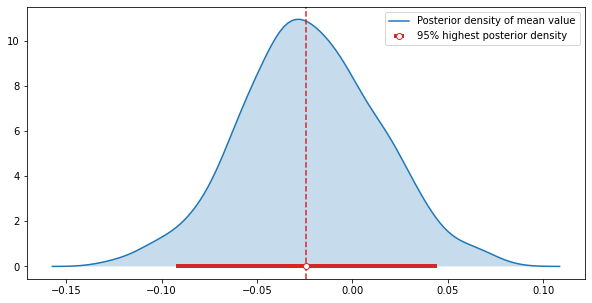

In [15]:
from seaborn import kdeplot
plt.figure(figsize=(10,5))
kdeplot(trace['center'], shade=True, label='Posterior density of mean value')

hpd = pm.stats.hpd(trace['center'])
plt.errorbar([hpd.mean()], [0], xerr = np.abs(hpd.mean()-hpd[:,None]),c='C3',
             linewidth=4,fmt='o', mfc='white', label='95% highest posterior density')
plt.axvline(hpd.mean(), c='C3', linestyle='--')
plt.legend()

In [20]:
rpts = 100
bavg_results = np.zeros([rpts,5])
chodera_results = np.zeros([rpts,5])
sokal_results = np.zeros([rpts,5])
correction_results = np.zeros([rpts,5])
bayes_results = np.zeros([rpts,5])
estimated_means = np.zeros([rpts,5])

In [21]:
import tqdm
for row in tqdm.tqdm_notebook(range(rpts)):
    for col, datasize in enumerate([30,100,300,1000,3000]):
        cor = gen_correlated_curve(0.9, datasize)
        estimated_means[row,col]=cor.mean()
    
        #block avg:
        s = do_block_averaging(cor)

        popt, pcov = optimize.curve_fit(block_avg_fit, np.arange(1, int(datasize**(2/3))+1), np.array(s), maxfev=25000)

            
        block_avg_sem = popt[0] *np.pi/2
        bavg_results[row,col]=block_avg_sem

    
        #chodera, sokal:
        chodera_autoc_time = statineff(cor)
        sokal_autoc_time = sokal_autocorr_time(cor)
        n=len(cor)
        chodera_sem = np.std(cor) / np.sqrt(n/chodera_autoc_time)
        chodera_results[row,col] = chodera_sem
        sokal_sem = np.std(cor) / np.sqrt(n/sokal_autoc_time)
        sokal_results[row,col] = sokal_sem
    
        #correction factor:
        result = AutoReg(cor-cor.mean(), lags = [1]).fit()
        estimated_rho = result.params[1]
        correction = np.sqrt((1+estimated_rho)/(1-estimated_rho))
        naive_sem = sem(cor)
        corrected_sem = naive_sem*correction
        correction_results[row,col]=corrected_sem

        #bayesian:
        trace = do_bayes_sem(cor)
        hpd = pm.stats.hpd(trace['center'])
        hpd_sem = (hpd[1]-hpd[0]/2)/1.96
        bayes_results[row,col]=hpd_sem
        print(block_avg_sem, chodera_sem, sokal_sem, corrected_sem, hpd_sem)
        
        

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1851.53draws/s]


0.1775414728967347 0.19671575297310862 0.1797101018984732 0.2189091263458386 0.5779104872256262


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1634.64draws/s]


0.8487580687296291 0.5635396371588551 0.46256010109946066 0.6452426294895117 0.9449296367739065


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1429.49draws/s]


0.7812688822268117 0.6761636200117869 0.5681957738929955 0.5369913706919309 0.7200098519976401


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1668.58draws/s]


0.3276931042827803 0.26486819214843976 0.26409952889847493 0.27079087828239534 0.3944548200842321


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1351.44draws/s]


0.23444000911178473 0.20670619940512897 0.21531067116984165 0.1793941923625477 0.24540785753258015


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1423.01draws/s]


1.8797646169129345 1.0830444565533806 0.6395117742959521 1.5649789450572582 1.7376939873283463


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1373.17draws/s]


0.3020403302113065 0.4186975049217826 0.3575071864920809 0.4991838434482843 0.7479348826867971


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1500.66draws/s]


0.987430340980957 0.4418952753887394 0.3871474623619931 0.38462318950287167 0.6198815601663963


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1319.67draws/s]


0.31014704684753275 0.2866006959203905 0.2765998090111328 0.28223147022169465 0.4685805531188349


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1121.48draws/s]


0.18791701329417504 0.16187597088810807 0.18226752041104963 0.1679963423489255 0.2007758812617746


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1295.43draws/s]


1.421327306180503 0.9164583109070755 0.5472141643378722 1.4336836801629325 1.2271149699996962


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1183.38draws/s]


0.6303436824684806 0.567907795358388 0.3918483700179168 0.6093122456556989 0.8619864870655317


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1336.40draws/s]


0.33281528088701057 0.3665012699482179 0.2623880800485338 0.47333506737740905 0.8430633902762817


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1682.49draws/s]


0.3555086939651867 0.32941397267906053 0.29116258577988285 0.2782886805323881 0.37718194822854595


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1474.24draws/s]


0.1608144734175902 0.16376685459668583 0.1516121164900192 0.16683998262322117 0.25098103345733785


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1315.28draws/s]


0.6106608736672231 0.5371546818564391 0.35039409675720334 0.599763590350409 0.937513347361418


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1596.03draws/s]


0.7246356994563761 0.5117427280807051 0.36942849535610395 0.48873505758730157 0.9424169888453606


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1418.92draws/s]


0.8195240274711044 0.691933087207279 0.5872607554068986 0.7974996112427798 0.8634191470387202


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1572.61draws/s]


0.21648771992521815 0.25301629201235265 0.19993309285861968 0.28192757498796994 0.4327137516780463


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1456.86draws/s]


0.15577280238844252 0.15209114524846587 0.14082196762020832 0.17124672306022698 0.2127464489219193


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1687.56draws/s]


1.1560952934091397 0.7827368067954318 0.47103561046590997 0.6686363869865056 1.4022412177144998


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1699.38draws/s]


0.4710981571585974 0.37557676703462306 0.30050099891073234 0.3833615706778162 0.7236797518418807


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1703.31draws/s]


0.4413957116718882 0.4096180231085905 0.3508956619018821 0.4558939832794241 0.6316383480931923


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1501.46draws/s]


0.28894304464649617 0.27161959374089645 0.2572922995529945 0.25527433405173927 0.5029241689301307


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1428.15draws/s]


0.19434326229567186 0.16482589767762723 0.18433218989474096 0.17111645430291023 0.29520044028388076


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1647.04draws/s]


0.53631145710182 0.4466926155498495 0.27677036221187123 0.5185189516218905 0.7164117474709938


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1525.27draws/s]


0.7231093922688712 0.6548280733162444 0.5123332998043512 0.6099662062508809 0.924354450754671


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1662.02draws/s]


0.5901440971463442 0.4946281228057564 0.5894002914474423 0.6497599140411283 0.837141198395588


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1677.37draws/s]


0.21975423092503013 0.21364648940576067 0.20822049695113515 0.2346151792479692 0.12965670662647402


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1489.56draws/s]


0.1721778265882496 0.18744368950825688 0.16644580688403365 0.17162149852597366 0.2731091182530847


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1441.18draws/s]


1.2681939228731067 0.8780075863787076 0.39302952704382205 1.3169205224550498 1.1091849323562313


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1802.61draws/s]


2.0013187223043687 0.352980948975431 0.3050413667770752 0.3250630091511701 0.4853386810105004


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1643.30draws/s]


0.9244341270529758 0.6325134232758949 0.47391227284235193 0.5172670932720482 0.6731410163937966


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1780.69draws/s]


0.2885107397705406 0.27445493608491306 0.23398488749021673 0.24526313731322785 0.2669209125405718


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1388.88draws/s]


0.23312292189456252 0.21690351682515205 0.21755289699947006 0.19089457951731406 0.21262959817761187


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1699.33draws/s]


0.9291379558867516 0.637428289068169 0.382436521605295 0.6352791378717834 0.857065751342666


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1682.86draws/s]


0.44578223494469593 0.38599254636537905 0.3780288114990627 0.40617199128235565 0.7507161207216687


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1628.90draws/s]


0.6231276677077319 0.5561102228485523 0.4745956726095261 0.461613801328974 0.7385055020091371


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1529.81draws/s]


0.4115688128280707 0.3278604309365738 0.3208242365615976 0.38573310099290686 0.4757332586460508


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1505.35draws/s]


0.18658266034493504 0.19377050078452138 0.17497065272271808 0.17508443166002804 0.22064720671952495


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1641.26draws/s]


173.19801503588167 0.675896217657182 0.40156682188004034 0.8442722616885184 0.9673884565043052


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1565.56draws/s]


0.818160604051244 0.7880077289916549 0.5882140932332987 0.8708625875564393 1.0436254925216377


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1216.30draws/s]


0.3267336853658787 0.3001610101064714 0.28674576725236184 0.3356353820187165 0.6753030289282935


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1707.77draws/s]


0.27229511750103685 0.2768967185479453 0.24558030111889584 0.27695164449045345 0.36724174058149217


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1379.78draws/s]


0.21514309472491874 0.22807978214043592 0.22722690196078987 0.16884397264350112 0.281663017861012


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1665.42draws/s]


360.5026679366411 0.5449651979153485 0.3343241272650903 0.6049947066100152 1.084382433129715


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1603.19draws/s]


0.6227917873152269 0.5511301564377343 0.5039485610517975 0.5856197793142386 1.0556934320064653


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1739.15draws/s]


0.3483725766008895 0.3645606420657617 0.3250655964913254 0.31148539363905176 0.6250526487159975


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1541.13draws/s]


0.43337917474074317 0.4098767746767121 0.38575637519426587 0.32757871225431967 0.666963476849956


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1302.79draws/s]


0.2896818881558292 0.26579260463804355 0.27069536920834486 0.1817865334760727 0.1915486627692452


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1763.24draws/s]


79.19150976235451 0.19623343562571044 0.14571289177243898 0.22240166516829352 0.483369420694841


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1565.17draws/s]


1.3443488292231245 0.9637787472354654 0.7237026117127379 1.307009561755553 1.401041173861969


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1656.90draws/s]


0.45326385490209264 0.40391932591414975 0.3318642462943938 0.441750694221773 0.5153843642811916


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1503.31draws/s]


0.4106355863466697 0.3841662515084069 0.3170399411836984 0.38679033062655627 0.6730693990096012


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1508.14draws/s]


0.192291561517978 0.19836307090289532 0.190825027396967 0.1941974396395701 0.32599544048251194


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1406.93draws/s]


1.9117771932475165 0.7944908486603602 0.4626750537674421 0.9507711512315455 1.2561852923814139


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 840.33draws/s] 


0.49872168425414093 0.37323957865674573 0.24075766790862888 0.40327094847994255 0.4878683875190469


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1400.26draws/s]


0.6535226611909777 0.547682349711481 0.40385736812475254 0.6146118358503144 0.7514594479276312


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1175.84draws/s]


0.21605429712850957 0.2166125484001333 0.20115529541282906 0.2499901702464266 0.39333896254253187


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1359.98draws/s]


0.26384373230518127 0.24903786864015803 0.2483312472333524 0.17779297675713696 0.30371202885938114


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1484.80draws/s]


1.7121117012971698 1.2492398120106527 0.8576369760994573 2.0357207323789175 1.9047236972864718


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1370.05draws/s]


1.840412112209282 0.9676997471234289 0.7156703551603909 0.9256524683967283 1.0388848311669054


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1600.89draws/s]


0.4933863234964045 0.47454675774332344 0.43042106388565055 0.5424320205668556 0.7264905491694701


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1680.14draws/s]


0.21504061094353535 0.24228215457077543 0.20975379291824517 0.28226880971175694 0.380648792891134


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1466.48draws/s]


0.19288537166755 0.16009881361043124 0.18478389049739263 0.1737793031074399 0.1883171646813524


Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1554.99draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


8.540543471000753 1.8455219851413869 1.0523048192097402 2.834418947013593 1.593353662374582


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1146.58draws/s]


0.9190593788061777 0.5450504954855633 0.4300784985513087 0.8069817916290619 1.1568990168227045


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1229.01draws/s]


0.5219380472919848 0.489339372010533 0.35270581511543014 0.5833245141265452 0.9144200149443639


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1746.84draws/s]


0.23860900105433627 0.2594694285954483 0.19935895631978043 0.26677963592495385 0.31095148750910917


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1353.09draws/s]


0.18338998311113808 0.1796493348192239 0.17848348615601212 0.17089590204361382 0.25791263997488256


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1619.53draws/s]


0.33455198922761387 0.3140310217218537 0.3078159717920874 0.4831549733420813 0.8133040265124879


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1641.42draws/s]


0.5795955876558782 0.6156798963439587 0.369569095902985 0.7184906910195662 0.8886354234966465


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1674.81draws/s]


0.6004273015721544 0.47458525648168426 0.4650955535854338 0.4126553187650169 0.5263260868741524


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1372.55draws/s]


0.21724328445662652 0.23143467405981646 0.19670398498668487 0.2618322546749613 0.38988993197464994


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1125.12draws/s]


0.18612845294635302 0.18974359006647554 0.17839228734352372 0.20160175580171558 0.2321390497905428


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1783.77draws/s]


154.3834699906577 0.8497097748964748 0.5101525325211327 1.2882786087707274 1.1345679280657048


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1459.03draws/s]


1.77830493349841 1.0929264067756181 0.7823498694993822 1.2584487618872164 1.0899482955564332


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1943.71draws/s]


0.7909878955296342 0.6905416836379026 0.5989671745389781 0.47678699639136557 0.7092996769748772


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1693.58draws/s]


0.2946896174193129 0.3032100296989333 0.2339653411170021 0.33905438397453064 0.39901950719740825


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1059.49draws/s]


0.19006149505384856 0.20233519866416746 0.18677991762829202 0.19083420891670758 0.20053186965347616


Sampling 2 chains, 4 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1324.05draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


4.563591076843098 1.0320908283480839 0.658690252115624 1.7325835163809131 1.0101755465252034


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1487.34draws/s]


0.481749621513137 0.3810866321392145 0.2528644708771754 0.36898954016180285 0.6045527713651835


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1375.76draws/s]


0.42750267226110233 0.3977451168510441 0.3016742074327644 0.4487686844936874 0.6218975036561399


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1593.20draws/s]


0.2995555705212828 0.27079744512998805 0.25924657772638066 0.2858040500346717 0.4103315726087869


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 680.40draws/s]


0.19619296597192415 0.18278133897797333 0.1805727732347605 0.17413678447207928 0.25388692128992085


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1390.73draws/s]


358.4968826561746 0.4644066048428525 0.28739270477335005 0.5534046684350421 1.0691906112237421


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 836.42draws/s] 


0.5466226785036372 0.46528843685270777 0.4036150899321927 0.6138849754403157 1.3531531398523982


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1412.12draws/s]


0.6247060585231431 0.47465779634920513 0.3960105895124672 0.4624852066790612 0.5137872254102354


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1670.45draws/s]


0.4015581435198943 0.3851203904737729 0.3446174422897079 0.41360326333213737 0.5355217856751064


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1589.10draws/s]


0.1905239301049696 0.18980289228670763 0.18439928945612552 0.1669445066079741 0.30434605706141277


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 962.92draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


0.19726501716849218 0.2622813575667614 0.16671540034110266 0.3355892225645495 1.5048370072680646


Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1371.62draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


1.2843021759449713 1.2183714379455681 0.8436930205108114 1.4768466254586556 1.191773667178807


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1252.43draws/s]


0.5912675769579252 0.7318867487286662 0.6771991906127026 0.6131397611742141 0.688256986988249


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1108.21draws/s]


0.38671572221907957 0.4141486891100327 0.37645077258130516 0.3687082482831306 0.5053084617622078


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 811.43draws/s] 


0.20887692240475172 0.1976073721051388 0.20803265760968462 0.186970170188265 0.24921025580898787


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1034.08draws/s]


1.4889291342272304 0.6278183839237806 0.3939704095549215 0.7704972200502216 1.4072498738502275


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1412.34draws/s]


1.4093832873287249 0.4725972049762015 0.4660480841686638 0.6601747044078089 0.7996044692774277


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1180.61draws/s]


0.40184773053927975 0.4105251945395977 0.3137965410837633 0.5998886255686711 1.0007265241033005


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 847.79draws/s] 


0.30816211370826246 0.30415745475701667 0.26213872413854294 0.3539809520810611 0.6156555580473873


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1044.95draws/s]


0.2679045269614124 0.273190321493701 0.2729695591358273 0.18723262605006039 0.2944057849715867


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1184.32draws/s]


1.2659121937389208 0.6478401148491082 0.38920840521198363 0.7543419218470068 1.5200223173755945


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1351.18draws/s]


0.4419450573801067 0.49641148693338094 0.4650561049264574 0.4011308787213311 0.9943185218974966


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1815.21draws/s]


0.5591379145392515 0.43303897454206736 0.39524615521975087 0.42796626562873685 0.7223975202131276


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1600.05draws/s]


0.3588401340633063 0.3310360539382048 0.34178407886223594 0.3581807688158834 0.47688159381538914


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1391.06draws/s]


0.20022039177948225 0.16493726016137675 0.2000972241763042 0.1756194944841159 0.2763968697383641


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1964.52draws/s]


0.2041017447853818 0.21993310077676503 0.14395114624083874 0.19822118145545034 0.5160171257212106


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1922.96draws/s]


0.680309295068929 0.539226895853981 0.4452367682082974 0.362590412091373 0.5039808949393073


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1762.21draws/s]


0.48597579896874943 0.43313528336172197 0.4855507267819351 0.5470070888714293 0.7408518799627896


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1801.47draws/s]


0.3030011323965275 0.2687733351548186 0.26088782439900426 0.2839253404793374 0.4044370617023494


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1272.30draws/s]


0.20842543444242292 0.20243965103554015 0.20244361502234098 0.1834628029939518 0.2652569842643416


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1610.29draws/s]


3.8274874793650664 0.5894449608328447 0.38620060115891314 0.7551648062300655 1.2469129091931357


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1509.17draws/s]


0.9910325122746797 0.6775129584656501 0.5995814147482373 0.7698828703364603 0.9543776484652121


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1487.43draws/s]


0.5558643573946324 0.4704774274029255 0.5226369056351018 0.609793290275381 0.738136681026318


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1532.78draws/s]


0.35378215258415496 0.31343676977453555 0.3197402673191953 0.3404522144233756 0.4872476362598709


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 736.85draws/s]


0.19820911406625727 0.19513480765607313 0.1873232646190607 0.17107971145838635 0.16961833122179473


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1800.76draws/s]


147.11482782715737 0.28318311193567797 0.22629086394941825 0.27004463847281057 0.6508686393458939


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1225.47draws/s]


1.3811532240626214 1.1013777481824176 0.7923475394754144 1.129136455051499 1.1131254414815253


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1606.61draws/s]


0.6660722998219081 0.5184056828666241 0.4465879633187022 0.4202335804895746 0.5986261698113285


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1188.20draws/s]


0.45444213862064664 0.4209246709664384 0.4101948482896576 0.4053527370669045 0.5336976263141857


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1139.91draws/s]


0.20202252675060567 0.20622360200066955 0.1930586061778553 0.20736478396179525 0.18313892614506447


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 675.86draws/s] 


0.9899957401665841 0.7636638547757854 0.5902676257536649 1.07147480695186 1.1204736136722842


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1285.58draws/s]


0.945098677465371 0.7589222559766532 0.6477314534062839 0.8548162698216838 1.040790763280735


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1037.80draws/s]


0.5235830622436211 0.5028098700276498 0.3841130533508262 0.5130815269662722 0.5797495918381462


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1307.80draws/s]


0.27931968210514985 0.2872320386289162 0.22641402364511956 0.3077951338690144 0.41229560504852


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 676.67draws/s]


0.2524345323853646 0.23399673835832532 0.22186516007002538 0.17841150308320441 0.21863959005115646


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1345.97draws/s]


0.33536227689896464 0.33413754404258905 0.3571543336006664 0.4646763788390154 1.1852288492024654


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1376.06draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


0.9271198629348014 0.826873655846912 0.5746323483583211 1.0509135055700571 1.1471692921915313


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1486.04draws/s]


0.4198972355380126 0.36622183736851666 0.3947574592086428 0.37827663198989 0.5523487475859271


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1697.29draws/s]


0.2730812564200423 0.2796040055127889 0.23254210870793066 0.28613461809545193 0.4551097358091561


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1475.84draws/s]


0.20030022730542363 0.16308517683004686 0.2078163267622064 0.1622633163832274 0.21551959874302898


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1471.59draws/s]


2.4417226067019566 0.9807085308606699 0.5562038305646809 1.40413851582019 1.4902172918641696


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1636.09draws/s]


0.8108897965264645 0.7138854971042031 0.5771361937334535 1.3267899524879716 0.9932900777438841


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1835.98draws/s]


0.25198194873769275 0.27906949768597966 0.2039710784127089 0.30814199827776784 0.40640639521430383


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1383.96draws/s]


0.2864982877837504 0.2865212952121241 0.2489624301691889 0.29697599579481104 0.3043247018912048


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1310.43draws/s]


0.20826580838728362 0.21547585562545546 0.194242388562797 0.1840457738986967 0.16565166830215944


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 857.86draws/s]


287.08734492158527 0.7230642664846537 0.4727101015339873 0.9339972230487603 1.2913219240321938


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 853.25draws/s] 


0.5384991689552325 0.6008750702036707 0.6528418152884932 1.0358898675002939 1.0226034524634282


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1637.44draws/s]


0.6656319272127031 0.5979551896315545 0.5172140064535692 0.723584423026869 0.7256655490228741


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 920.91draws/s] 


0.2036864689059524 0.23175776981608423 0.1810068225688533 0.2557568360494944 0.2517756888057576


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 675.79draws/s]


0.22163685327514357 0.2031279853642988 0.2085207558532791 0.18164332196316121 0.23973213703386245


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 550.94draws/s]


3.0720280001602447 0.9994326654756305 0.639206931050541 1.2951643335217053 1.2664702199988374


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1383.40draws/s]


1.376429379007051 0.5592692539922549 0.3774514521618829 0.6452366924522013 0.7910178919492


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1397.82draws/s]


0.4143407902947615 0.40127047906068836 0.2867673848790794 0.44721459930959706 0.738701514891038


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 712.57draws/s]


0.35976559729905927 0.3000756907038594 0.26783171949492224 0.26323622203215025 0.43656387332113655


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 695.90draws/s] 


0.1519143492385616 0.15741895465171563 0.13811833374383062 0.15149821678584824 0.14424263398817683


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 572.99draws/s]


1.2598242419196826 0.8345993896367866 0.49413811286961673 1.2826629603078326 1.2389682104779753


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1479.46draws/s]


0.2557978767575349 0.30491682110147744 0.20078805232669028 0.39048801180256615 0.8268106329379613


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1330.31draws/s]


0.32864957758526475 0.33962840927541543 0.24907034839622758 0.36477317116488783 0.5498565526715551


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1570.97draws/s]


0.23763551056355958 0.2241208181016884 0.21760202812599294 0.24194134354981062 0.32043852658942795


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1118.76draws/s]


0.17953656522806785 0.1825567397435639 0.1574253431575793 0.19362812004868676 0.25875020543303395


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1496.88draws/s]


1.7529761726324231 0.5212172425294663 0.436069483960598 0.7511841346436218 1.4550854135103286


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1491.88draws/s]


0.6589667121912225 0.4615193910694155 0.4908417857325215 0.48947393168461656 0.6199177173705849


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1364.04draws/s]


0.5737269332695069 0.4901070681549263 0.37139834367093505 0.594140156725316 0.7922607410179565


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1183.97draws/s]


0.2625340191695283 0.2725728462452484 0.23047379203713822 0.3262468282805317 0.662350751538325


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1053.48draws/s]


0.17701237866188171 0.18901153530517575 0.16842801069141028 0.18938046764651809 0.22319310735123898


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1528.06draws/s]


6.268380274000467 1.0748111228840571 0.8037338030334407 1.2920309762784645 1.916908843382388


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1064.03draws/s]


0.7710038171561459 0.8374444837319471 0.6205596342944154 1.2534295399287316 1.2014541175986941


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1672.66draws/s]


0.537252870025627 0.46481285823951235 0.39049342377094415 0.47636191079765494 0.6139271447281618


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1337.23draws/s]


0.23413809142231834 0.23057129266167406 0.22034964933474172 0.25332118616105426 0.4253190782032551


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1206.43draws/s]


0.19953003072689054 0.18312609117379372 0.19952362256955042 0.18611260680825556 0.33259446822154065


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1843.68draws/s]


0.1810863851684402 0.1536092026108118 0.15402584814275574 0.24536764946119555 0.37910384081075404


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 660.07draws/s]


0.3109070659762947 0.39147098791942053 0.2555615730960482 0.5260037742878223 0.7493862710608926


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 742.75draws/s]


0.38082749300251584 0.33415916470872525 0.3082596999880366 0.36344128267961956 0.6127343979369966


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1441.16draws/s]


0.40518805861372775 0.2942399793733618 0.3337946849551994 0.33834261697481055 0.49938088756967225


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 587.46draws/s]


0.1703688336596339 0.1708846294650206 0.16310541970523093 0.1503495909663888 0.28888942731793876


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1299.10draws/s]


0.6472066352676058 0.4521702024238416 0.3184915833950223 0.6782671685823919 0.8708965399180957


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1440.47draws/s]


1.2934527896136483 0.5876134614698448 0.421328361942313 0.5646368288967054 0.710499799603674


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1407.76draws/s]


0.48629690354436406 0.42625957417102833 0.32700221472229646 0.5315325322165153 0.7982758330801394


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 565.96draws/s]


0.33479280074844275 0.30002413211433193 0.29495980659296084 0.3212204843703616 0.46763024038294854


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1245.21draws/s]


0.18218872515175108 0.18221165949812226 0.17287415542238105 0.1952697073773093 0.21466773118686927


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1368.72draws/s]


0.48680950504453724 0.5317022394507648 0.21336236714806467 0.6684842522755219 0.8921369261397304


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1312.15draws/s]


0.3116064995745823 0.3252768493086109 0.22400421252015834 0.3737468677540795 0.6908845692961338


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1288.13draws/s]


0.6188157178313378 0.5417343305360218 0.40074372730184094 0.6244796276821929 0.9046107302226761


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1496.79draws/s]


0.34823912558885206 0.32978210449548123 0.3904455348534413 0.3435304369952803 0.5040518436393044


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1193.29draws/s]


0.20824929256833985 0.21205614620816865 0.21184271206435867 0.17444279559178033 0.19854545045508676


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1402.96draws/s]


1.5413099588610415 0.9662286230339514 0.5492771497524488 1.6343240172649345 0.9805882006780958


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1446.01draws/s]


0.9674222881671486 0.8480830077498644 0.5383544639479549 1.1454030290606894 0.9650500313006036


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1735.62draws/s]


0.4708971257058685 0.3974917540134921 0.3902425904470175 0.43262350798649035 0.4911762066605434


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1713.28draws/s]


0.24729146066914048 0.2452099118761947 0.2376655266960935 0.2879224158478229 0.4424337330768339


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1415.70draws/s]


0.1758803628884714 0.18120691712969486 0.16224281784924882 0.19024950624688544 0.305754258042933


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1690.93draws/s]


82.65317093677776 0.33797230434172537 0.29025063457577 0.4339150492813813 0.8238813309800764


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1690.13draws/s]


0.8217349888756038 0.5617514210024148 0.4864517002624683 0.5682694942217452 0.5930115047816756


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1808.96draws/s]


0.4499638500467926 0.45860213892492124 0.33799213119291627 0.5849133426851202 0.6787069882809058


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1428.92draws/s]


0.33081731362810735 0.3327066694897861 0.2514909202021081 0.355080122049177 0.3621736021854554


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1204.88draws/s]


0.1921531223808153 0.18297550595351855 0.18528396484650173 0.1741313813859037 0.20221312730232407


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 449.09draws/s]


2.7809716531360316 1.003395633965294 0.6027266397866925 1.2922293563359768 1.1885728894166356


Sampling 2 chains, 2 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1325.74draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


1.7666845027799485 1.0870155773206063 0.7075201409594946 1.1155235914318113 1.0491005099624955


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1702.55draws/s]


0.4745421794461975 0.4241477346939336 0.4531204244562684 0.488488331254526 0.5314537000011111


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1528.87draws/s]


0.2770850363826961 0.26185211698694355 0.26740414064370854 0.2716658271719474 0.36865460540628403


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1030.44draws/s]


0.17889818855616935 0.17065944989494272 0.17843776712614445 0.18055200540861352 0.26182326546652285


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1278.97draws/s]


0.3599074733769311 0.4020006487074424 0.2798037034188761 0.5654715761961456 0.8210469436608812


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1689.72draws/s]


0.4835449687407226 0.33134929536488084 0.3249684223637112 0.3296358902034251 0.3961766806933809


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 477.30draws/s]


0.5465941680119567 0.4621329195226847 0.552022184309512 0.6018624787654616 0.8905309411664333


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 661.69draws/s]


0.3427617472579805 0.3046407749773335 0.31173265842218095 0.3156853991319039 0.3478240534801444


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 834.64draws/s] 


0.20197280587866515 0.20946320982908218 0.19177055662192496 0.19304820800656738 0.2407407537232123


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1567.48draws/s]


0.8939199896388605 0.7468738382644616 0.5156238021517442 0.9620547611651055 1.1306130261703944


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1523.59draws/s]


0.8842015176568322 1.0021736911706374 0.7608274735579457 1.1343622652443748 1.3137000903855762


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1340.63draws/s]


0.48354367439921525 0.4758652626253213 0.5187252492165311 0.6205427670514299 1.0375831151335126


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1255.12draws/s]


0.37466427765785376 0.36011276886765475 0.3588763390802071 0.29736386140313337 0.5127563048177253


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1272.21draws/s]


0.12553727009795634 0.1602263457561981 0.13306223709416126 0.18160963617527318 0.2559775492794088


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 851.70draws/s] 


0.33778516915970513 0.4175354472070236 0.35297557634333854 0.45606551100989795 0.752710850371752


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1385.51draws/s]


1.016196971537362 0.7586847603878923 0.511131238939506 1.0374863678657522 1.2671305720638988


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1610.38draws/s]


0.280187989474519 0.29563283695878284 0.21982016845492902 0.31248370068141695 0.41382241739833153


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1657.76draws/s]


0.3662995045861432 0.3792079090800446 0.3616551603635595 0.25358690791962174 0.41177109197002093


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1458.82draws/s]


0.1710302466868382 0.19650061624956747 0.17141153375948776 0.1877354071559833 0.23778953872541522


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1213.58draws/s]


0.5354533631021944 0.5198325181508283 0.382106541304986 0.7250463079929861 1.183948331061097


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1317.15draws/s]


0.9546924211065564 0.7137258742089267 0.4423944812910726 0.953798037495527 1.1936973337051338


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1572.66draws/s]


0.7157923796508395 0.641638930583854 0.5273087476257624 0.6404187288157243 0.8084023458114652


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1656.68draws/s]


0.19296158706707034 0.22325090813288015 0.15564281357016418 0.2678930539795419 0.3736410179883518


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1383.84draws/s]


0.19868776589124604 0.18951563645004144 0.1937801540966416 0.20053523335230067 0.3029677347587762


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1705.99draws/s]


1.5192609765940415 1.4161110979411138 0.9894886775002569 nan 1.4177371780251946


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1283.40draws/s]


1.0377863319786707 0.6317020733396935 0.5058844895833547 0.900464724315951 0.9773548637159328


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1718.93draws/s]


0.4364400094355081 0.40661336317060925 0.2976695709252044 0.42333679538612484 0.5698074227897886


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 882.07draws/s] 


0.3056078270997437 0.2811024907664927 0.23367365780631863 0.2853549503019566 0.3335385339946843


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1354.90draws/s]


0.14302233775857834 0.1568668523071928 0.13313014817399643 0.17028407050438635 0.21656288695266457


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1752.90draws/s]


233.8960967729914 0.3872601472916355 0.15531764325409333 0.4021433953317353 0.5881570898852037


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1797.68draws/s]


0.3719445976141488 0.29780588656407636 0.28427858350417495 0.3515923154735593 0.5191297871767344


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1729.08draws/s]


0.4078401147422451 0.3896734515771892 0.34375971247143683 0.39455719202094974 0.4748796173205546


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 542.90draws/s]


0.40943151710074477 0.3445586744739726 0.3969779663434278 0.3379279045158298 0.5179412178344903


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1321.13draws/s]


0.21609795071508234 0.1899617722736251 0.20158354012984522 0.1886283039125503 0.33609740789702075


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1502.26draws/s]


0.6101807169209651 0.7432078730370708 0.46561065212838926 1.0142841927340387 1.2874944542235016


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1624.87draws/s]


0.5697239367923056 0.42145184120551105 0.362394462249855 0.4834935610221621 0.954635005895625


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1146.09draws/s]


0.4994589081584294 0.4346940550858951 0.3828563846298375 0.4057472451849258 0.5471927597525845


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1760.31draws/s]


0.4059892329199012 0.35545698472888587 0.4998175653245916 0.3161784553286392 0.5104775242426641


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1528.07draws/s]


0.25094946125468903 0.24523224121728007 0.22999527091013797 0.18404167000929822 0.2664071998886278


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1730.24draws/s]


0.28152364709405076 0.36055329389627255 0.24589469211775153 0.34813648619127513 0.6021393091654456


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1602.42draws/s]


0.6903244182292614 0.681462601117773 0.501874449829312 1.0007750023691944 1.219699934520798


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1828.03draws/s]


0.5498924600664882 0.5186581861579478 0.530713827274929 0.5648507188607971 0.8141384992991307


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1873.73draws/s]


0.22588840768965782 0.23864254477163602 0.20753912877951888 0.25324323176431834 0.472155073778334


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1519.45draws/s]


0.12625078311183174 0.15388027919149366 0.12272938890192084 0.17750474107808026 0.1902568071359213


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1832.93draws/s]


0.7924499788010555 0.8371087467551014 0.5209529581524165 1.4415934984695007 1.1680387654681121


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1878.02draws/s]


0.4741114960544898 0.4520613867789225 0.24897738643865744 0.5876256745621029 0.6966334448976169


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1695.65draws/s]


0.5718360593338581 0.5094315785908263 0.4199490499210815 0.6130460364012456 0.8930637658688747


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1771.30draws/s]


0.3487224073261339 0.3378811303079358 0.32365646243820484 0.30905505421758994 0.5000069581613191


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1564.77draws/s]


0.16396098833474876 0.16982179934086888 0.1468798626778368 0.1845487670386748 0.3542240697005147


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1959.22draws/s]


0.1918646164242473 0.2187942253721317 0.12747989356897124 0.25027725599700124 1.2413604871453459


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1872.56draws/s]


0.6764819035563948 0.761863763307099 0.6255827213267464 0.7233795323525849 1.0138021000302377


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1751.37draws/s]


0.3535221588518116 0.3220790008698524 0.32583733799673575 0.34206101285819734 0.4110972780610992


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1829.02draws/s]


0.26772386236503937 0.2462038421054629 0.2374513114920732 0.28362911352937303 0.377782072090016


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1573.79draws/s]


0.182792927215819 0.1816829515289737 0.17541071397336408 0.15926568669200977 0.3092012112219338


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1742.44draws/s]


626.3170397024869 1.0581157290046752 0.6184223313572978 1.208264352595088 1.1807890033238888


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1914.75draws/s]


0.4511090036639681 0.4147793318432422 0.29464101344333987 0.4049364523328442 0.6546834932126114


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1878.00draws/s]


0.35130513935057833 0.3198294723943006 0.27634488147512837 0.3862422132953187 0.6379791825941935


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1641.26draws/s]


0.26441501349716867 0.2758038432763218 0.2279300813378305 0.2848125692668828 0.37160072905893743


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1506.21draws/s]


0.2010033118852553 0.19366357245437035 0.1977637424524717 0.18891721137967707 0.23284515632943


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1243.34draws/s]


0.3557219252917656 0.4363150293590977 0.3073189519202698 0.49370100383394117 1.0896853165795124


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1219.38draws/s]


0.6782721646722398 0.6645534882121019 0.399423104246022 0.8235432482242723 0.8926070484166573


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1666.63draws/s]


0.7751229407354204 0.6290128426843278 0.5680899268227707 0.6814804156396631 0.9262145624021408


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1498.05draws/s]


0.40076736148834236 0.304982280085825 0.29028129620454446 0.28994820140122657 0.4982898144584494


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1266.42draws/s]


0.19797975721425157 0.1992654138192461 0.19414328103716993 0.20251009349617718 0.26603297985962476


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 920.30draws/s]


3.7567940560516155 1.1672178018792765 0.6804549734593154 2.1935225061342494 1.5667800923728177


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1642.06draws/s]


0.6810565261448842 0.5646907158357047 0.3610236598558526 0.7367550461338747 1.1793500907790246


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1497.25draws/s]


0.9413296082604445 0.40619846263568776 0.3773441691067639 0.35799637400566714 0.46906108267360275


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1568.75draws/s]


0.36238300978107835 0.3251388346127607 0.2787860502144926 0.29213112938577396 0.5245333531235202


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1118.14draws/s]


0.17771329966709815 0.17943535272663777 0.16686744422226765 0.17454056874189156 0.2998748332726931


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1585.54draws/s]


2.2139115706636323 1.1947142289255754 0.7088274701171158 1.8354443836020031 1.3755148560958281


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1449.10draws/s]


0.5132163570277994 0.33407568577927094 0.3781798648520408 0.43010801168534063 0.8160299096685516


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1247.62draws/s]


0.5369196948308221 0.5378456949068218 0.47563310019794125 0.7074309770954731 1.0199908386712766


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1453.56draws/s]


0.3257187216771365 0.3104674218261809 0.28400285763751637 0.31942907636367646 0.37280924492340334


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1126.46draws/s]


0.2150846565746109 0.1965214412704586 0.20253629759444583 0.18350726037882398 0.23604531468138476


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1279.91draws/s]


0.2136200293106617 0.2551487694261103 0.14072422659023337 0.3234182996709902 0.7348588706196294


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1208.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2.361548852126914 0.9066323301256748 0.660983330230962 1.1337096795200547 1.538270075419331


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1281.51draws/s]


0.6561616212438184 0.5103763387157126 0.3867834474185106 0.5091218256421597 0.5415102910707936


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1660.71draws/s]


0.3424940698421242 0.3000784630426187 0.306349829522102 0.2815862726225892 0.38594066992265896


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1551.02draws/s]


0.20291411686647717 0.19800321162007828 0.18189249672263796 0.16776100024910665 0.2015068992602774


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1250.34draws/s]


1.0219062699196422 0.6199341626399384 0.41940178249242227 0.868582477268564 1.1347390672258102


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 894.44draws/s] 


0.5765479817079417 0.44535600064773484 0.4321298352822118 0.5770410697752758 0.7872469682586233


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1477.64draws/s]


0.7921705063279575 0.6239998262981019 0.5321878038892173 0.563777797573698 0.8307564802119765


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1308.84draws/s]


0.3340525831968138 0.29696319277534106 0.3290532803498224 0.3598839452709763 0.5433091829284884


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1369.35draws/s]


0.13676236300027755 0.15585319256659644 0.13833550955177393 0.16712323309976784 0.1878980000202824


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1476.54draws/s]


1.9592034896321908 0.8073162265426902 0.6364165357720257 1.641457926361816 1.1283702618255456


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1512.93draws/s]


0.8512650532112656 0.5704464898375484 0.44111728761719854 0.6048555264527343 0.9253013037967143


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1531.96draws/s]


0.5581716560868278 0.5637257787652715 0.46572498599282935 0.642520410340414 0.8556775321797482


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1605.34draws/s]


0.4552914197964751 0.3903931262560442 0.3976415275622676 0.2726208806899546 0.5038404660266158


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1372.61draws/s]


0.1662904090375172 0.1619242636490825 0.16023516193851908 0.16881370611595303 0.30454950015987714


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1066.13draws/s]


0.5147175156131937 0.4693497683239484 0.3980775585395831 0.5903766071243449 1.0681693865769188


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1526.82draws/s]


0.5102379581965739 0.565190727052818 0.39421639979146256 0.8099201028337835 0.966884784599871


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1636.88draws/s]


0.6602716584562255 0.5042004758091537 0.3974620380590587 0.5438045514674347 0.7263710284238798


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1656.32draws/s]


0.30992420637770357 0.30303581722786965 0.27981492703070737 0.2592367556390106 0.29014220725332757


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1141.03draws/s]


0.18170932740850043 0.19659541217879783 0.1728786753593973 0.18582089079696038 0.2168505604351358


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1627.99draws/s]


1.285676241318278 0.9658042017390962 0.5753479496620629 1.1073874939070845 1.430558088258342


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 798.29draws/s]


0.7204322096712458 0.7929375540398867 0.5857155973315928 0.705763625901068 0.9678172962308713


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1213.40draws/s]


0.5567684866222842 0.49399143281783225 0.3719101950202836 0.6544096974007282 0.9952415595341063


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1819.34draws/s]


0.22643583709033266 0.24329503913645137 0.1972237709060733 0.2634261486313758 0.32771266201634636


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1288.85draws/s]


0.1585690528308405 0.16539219658104642 0.16284647494947968 0.18165199385743755 0.2646696135152358


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1469.07draws/s]


141.10976266709645 0.3029966642522538 0.24347235524977842 0.3097310489684796 0.598248797294143


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 683.23draws/s] 


0.9315176413857881 0.6118832097290884 0.5535520286551604 0.6356880742994764 0.8333073403669456


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1583.92draws/s]


0.6014195927355637 0.47083787684733 0.34682182958477537 0.5218203312463028 0.8026349190645694


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1227.43draws/s]


0.25302674254438234 0.26201982404291174 0.230232136851878 0.24647061272238188 0.38507807177668735


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1383.34draws/s]


0.19996129627369735 0.17367479497381924 0.19728693141906448 0.1799573364507872 0.26237115268116423


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 934.50draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


0.31730360245774697 0.287120059019806 0.19646663283568655 0.32224376168387747 1.318507925798663


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1853.23draws/s]


0.4718318312325056 0.34082818855611363 0.274691794539753 0.21768337705643834 0.19919051393458292


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1669.98draws/s]


0.5274765667400342 0.3710929062097665 0.3125027957599142 0.37201526454063727 0.4396069979954516


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1698.75draws/s]


0.31651279915682934 0.3031299303034757 0.34339237682097196 0.3352506108154917 0.4067992252751218


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1502.38draws/s]


0.24713917286751175 0.22703764451038214 0.22175360079939693 0.1851591361375257 0.23536639679332264


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1675.33draws/s]


0.8069384585010463 0.5688111972756261 0.24158044872840956 0.7932192883492022 0.8207610680611659


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1549.64draws/s]


0.5939108584604381 0.4648244631867834 0.34052732870215535 0.4327065316559554 0.6757714668552696


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1790.21draws/s]


0.7992725838409476 0.6495592990901021 0.5805438915805129 0.7446522499604469 1.042983413933045


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1800.26draws/s]


0.31091198286545685 0.3094654143281795 0.2608450141028106 0.3102269311144452 0.4265811174193536


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1005.74draws/s]


0.1462008366081577 0.16259365045809696 0.14758560054372263 0.17492165478201796 0.29573613348100763


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1587.14draws/s]


0.5735063446732471 0.5438935495801908 0.2967784818402497 0.6712334482143403 1.0365161468183774


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1780.11draws/s]


1.5272526758500846 0.8593468790643222 0.5930505421265655 0.786459608528951 1.0012970561290884


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1716.82draws/s]


0.5822591924930709 0.5481279474581713 0.38301066114107046 0.5680822502270865 0.6971689674433208


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1798.67draws/s]


0.2601492792743275 0.2426320933197687 0.22630886435645386 0.2732580925294871 0.4082383629675712


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1513.98draws/s]


0.1769903329450572 0.18107973896630714 0.17123630160245756 0.16216492520451967 0.211671765506225


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1550.04draws/s]


0.8214420852583011 0.8390567659797054 0.6190555782888256 1.2748080261030856 1.340527722123027


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1362.63draws/s]


0.6862113194735062 0.5528732647157169 0.41632101025460094 0.6382416918892715 0.8185073345449237


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1393.72draws/s]


0.6035475347306246 0.4988450537045423 0.5663876928892421 0.6172753361272786 0.8090183370530005


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1518.41draws/s]


0.3747694560090121 0.3162345908597507 0.31001344732832264 0.29586235662015237 0.46518699970486194


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1320.58draws/s]


0.1803531275490575 0.18566003862295358 0.16460428758743587 0.17495610840848447 0.16689058993766498


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1465.06draws/s]


0.38728821096479904 0.40537758592185713 0.23832325181564357 0.623230032021631 1.1860487327559948


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1423.81draws/s]


1.0730199081434206 0.8807952174732584 0.7751670049539255 1.0277167948171646 1.1793128835809288


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1628.64draws/s]


0.6652328611017315 0.8014611989779846 0.5836666408335768 0.7244673512459013 0.8620669603342546


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1547.71draws/s]


0.2599263077255234 0.23078392665837455 0.234103187421326 0.24393621264676316 0.31230761834589793


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 645.25draws/s]


0.15728013411261707 0.15919287435000243 0.15910393717933838 0.16154762326216682 0.1692299537836156


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1149.05draws/s]


1.0705120284124021 0.6885783623200472 0.4383985490222038 0.7518739432818294 1.0574308584198426


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1609.21draws/s]


1.5761651810740942 0.8167932360699918 0.5126302378065192 0.9947382221566052 1.2657375665882473


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1454.26draws/s]


0.5016561880912966 0.47538682364903934 0.48439193135015446 0.5378817455716182 0.8391439527298495


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1682.43draws/s]


0.24115742791659162 0.2460471556126554 0.204963303462093 0.23760483279145783 0.43456206503840766


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1056.50draws/s]


0.23529685261145572 0.20668081827643278 0.2331876597783781 0.1964653397495552 0.2788315419811274


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1692.48draws/s]


11.836002107895958 0.2754002912956425 0.2504808880996196 0.3383551001505874 0.8036383340051508


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1486.47draws/s]


1.1103495317346437 0.8563243492940326 0.5504431254000848 0.9584311355271768 1.080647667508869


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1787.19draws/s]


0.4701969575356075 0.4530328714483414 0.3161137139539585 0.48587388497606315 0.618827715183955


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1550.67draws/s]


0.3198361619927883 0.30546716800068435 0.2775372517804048 0.3161584065701286 0.4049727981968063


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1148.60draws/s]


0.21485066491259766 0.20989557710757134 0.2004809980579448 0.21400233754540693 0.3552603518364715


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1443.44draws/s]


0.8464436073877766 1.0297111310845044 0.7174362438458796 2.483260713207272 1.263694648206908


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1737.87draws/s]


0.6039090325048726 0.44954903990854106 0.3569065269834823 0.5152901456769726 0.9616080668724478


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1408.94draws/s]


0.3622114118240459 0.32559973398767045 0.26665555861990475 0.3620780352780893 0.4483015978497335


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1509.41draws/s]


0.3772577934459329 0.351700875015502 0.3058250435617292 0.35009617541076476 0.46597904659725764


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1426.99draws/s]


0.17672397954935665 0.1714799303218345 0.16275163797024994 0.18870377926725931 0.30535569823401304


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1441.27draws/s]


0.46811378226854167 0.4226152577544994 0.15294852145895385 0.6214197756255592 0.8719852442523516


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1317.92draws/s]


0.7839911996725352 0.5106164834254917 0.40577696026015275 0.5037484265031454 1.2070993229779958


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1449.75draws/s]


0.6730504536959336 0.540233214253042 0.5026977390382374 0.5386686421520386 0.9258498345674273


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1397.79draws/s]


0.36154803621927706 0.3155189901269337 0.3298555037887246 0.3456741554269557 0.47723275513494245


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1059.96draws/s]


0.19001477931455774 0.19497750027910635 0.18820825718280002 0.18579943853214406 0.2270803948110535


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1277.60draws/s]


608.4734645726838 0.8014457551860436 0.5154418859010031 1.004705912658659 1.0938918035152465


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1459.19draws/s]


1.1768892047893826 0.6812812963363265 0.5175788952047058 0.6682865883007336 0.8057916964354904


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1541.12draws/s]


0.49437307777793543 0.45430108424999366 0.2955675787043118 0.5193428182533433 0.5988674653831044


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1401.59draws/s]


0.41658382346139566 0.3303659240927114 0.2914562427426072 0.26805238298022227 0.41991943239434326


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1519.50draws/s]


0.15528166045417133 0.16929495725868837 0.14442827293749458 0.1892613622578549 0.24222802231655025


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1635.10draws/s]


1.2509641618709075 0.9942025599134039 0.5800110103973718 1.8645322820499124 1.383500378581444


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1915.62draws/s]


0.6751872170963691 0.5736389022837863 0.3822581224893913 0.7544926142152822 0.9164539907477621


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1695.00draws/s]


0.7205501515781517 0.5849893027503626 0.3617950831917529 0.7213837603513498 0.8447466665812928


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1620.97draws/s]


0.3671882729621907 0.3041227357118025 0.29018480932927165 0.32822228450629587 0.5718055445429351


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1478.59draws/s]


0.19462968048549711 0.18829802618040026 0.19951698137900636 0.17833566354016903 0.23202880574989276


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1277.91draws/s]


0.6163275818543261 0.4058849704518103 0.2764764913043075 0.48965272154851747 0.8864051766989721


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1737.29draws/s]


0.6396073764981794 0.4959131017307134 0.6509760301796433 0.7302383326198931 0.9521435688959753


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1558.94draws/s]


0.8698664150447359 0.5811903720214245 0.4876550699997371 0.6080605827450642 0.7265374439762464


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1471.04draws/s]


0.30050494461190164 0.28908739428941027 0.3202637377192739 0.3291410554732779 0.5193737516249713


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 855.53draws/s] 


0.20781171162602505 0.20122423168682915 0.20871342329285064 0.199201350451296 0.31992005055878114


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1349.88draws/s]


165.45803892791002 0.4215500559792748 0.3362586960103542 0.43741644633209104 0.897267009067749


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1241.29draws/s]


0.5234436201585222 0.49446503120018054 0.3185437945887008 0.5825458299336713 0.8054336160263112


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1387.31draws/s]


0.43242737496051353 0.40593910560717883 0.2915548843312067 0.3599813162903552 0.2634566164612401


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1274.97draws/s]


0.3680718103816974 0.3095713504727558 0.305014700179895 0.3341887598901436 0.4544336841223466


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1210.18draws/s]


0.179716534122872 0.16919294097046403 0.16461506552613878 0.1581199069740349 0.23473447450893614


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1220.53draws/s]


2.3776389682399723 0.7329718630990368 0.5459027106233623 0.9664219527882993 1.3533101827559337


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1720.77draws/s]


0.584590708601321 0.5048947167220431 0.3431893490034834 0.688882249653039 0.7997195440887483


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1671.50draws/s]


0.7671855896264975 0.7611265063564951 0.501853412060168 0.9287277948054077 1.038747068274499


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1813.81draws/s]


0.32489401874410423 0.2864089350474448 0.24298557693332176 0.282156414708289 0.314023791980402


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1516.41draws/s]


0.1913062889024614 0.19255676964507942 0.18946099000811634 0.1834995393381278 0.24068571579202344


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1756.00draws/s]


0.2449803473390821 0.18835286237993668 0.11126932199798574 0.30550317088438367 1.0506749984841635


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1703.21draws/s]


1.0487157711842428 0.6905675835846923 0.4695233178795432 0.6221293251383287 0.6709310320415605


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1883.70draws/s]


0.3895553019598965 0.296044339019491 0.33154565406956427 0.3040384746462891 0.6548270883769555


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1658.91draws/s]


0.44166117949493855 0.4098173717011523 0.333234209649124 0.3768188379140158 0.4542116541311364


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1624.88draws/s]


0.2455824210003044 0.19912871153712308 0.26943232591186866 0.19467106144756394 0.3243709210075716


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1813.47draws/s]


433.5447582809109 0.6624961058304237 0.4451448601283276 0.6168144725620424 0.9253254177148906


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1698.12draws/s]


0.8984171846133673 0.7090472059533648 0.573357424842342 1.075576465169414 1.2468806171236964


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1550.76draws/s]


0.3359722589747646 0.3272985291095343 0.3232178575025588 0.4250416598523873 0.6485693638402861


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1726.95draws/s]


0.4312991565376275 0.32233690056461994 0.29220238484018224 0.2725524349163412 0.48013062838679554


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1376.20draws/s]


0.13877770102185896 0.16080975678168233 0.1348125744883022 0.1677939602874564 0.2600211204556163


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1672.30draws/s]


1.0191335028138684 0.4142892693850085 0.2561283303936861 0.5627111481700542 1.3743888824549875


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1900.25draws/s]


0.3825813644915471 0.3183735132459687 0.2848506135740502 0.28651382503825445 0.4967228688752372


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1560.83draws/s]


0.8831725260652439 0.7266962524308438 0.5633929927915268 0.6869353323547567 0.6978702012865944


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1732.38draws/s]


0.2969856046730033 0.31905091292459525 0.2550466191659442 0.34114641438391463 0.48049306824573146


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1452.70draws/s]


0.15801692372325493 0.16811979133024468 0.14238436894665574 0.17444474022055362 0.3060603786622361


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1796.69draws/s]


1.2514724328435087 1.5814365820040952 1.0953532612770482 nan 1.4267645742357065


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1756.43draws/s]


0.584201188680839 0.4930920635706783 0.5961176154829342 0.6395296674834331 1.0001401466556645


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1841.25draws/s]


0.49559732174364046 0.4093118182407001 0.4749610951933755 0.35017364478263474 0.39759803136916466


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1749.92draws/s]


0.2466020117358207 0.2536877436998962 0.22312767887785528 0.29983740000828174 0.49503407562888063


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1529.95draws/s]


0.179584668783667 0.14947792019506045 0.17891565228148287 0.16512242983192582 0.15412127469195827


Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1748.44draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


1.48677638470185 1.0253545152937336 0.6329642255196053 1.7965598355079353 1.2523875448381139


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1813.50draws/s]


1.1785332269617028 0.8095870914343115 0.613103041543841 0.6662123665500682 0.7894442116761001


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1489.81draws/s]


0.8382560259458736 0.7370435650331758 0.595179142287563 0.8755399218996447 0.9196876654876989


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1670.53draws/s]


0.2797721118773678 0.2998571545907997 0.227902978919773 0.3434866845236107 0.47426661875839626


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 905.41draws/s] 


0.21117259787012588 0.21455874384166312 0.20429593268042295 0.18156595849836596 0.2471436770596736


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1754.76draws/s]


1.046801457477692 0.6088580651425571 0.39459126351916657 0.7012091276709547 1.087521094643549


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1717.01draws/s]


0.6880677815502588 0.47496390209403927 0.3381537870158586 0.6131177112686975 1.2544350573065994


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1904.07draws/s]


0.5605332580023086 0.5721689007601858 0.5454854665804177 0.39358445911025947 0.7320599660727765


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1638.81draws/s]


0.358503116245085 0.35570686039705424 0.2778007873635013 0.3471506077534159 0.5246527372464388


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1584.42draws/s]


0.17861084592637552 0.17466247178985975 0.17589265330215823 0.17233056644927683 0.30286843861008783


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1853.00draws/s]


0.7421688574223684 0.7982497548498825 0.596677383659232 1.3109715168045062 1.1492334761041083


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1800.47draws/s]


0.5212889202453276 0.4401273268222602 0.4817079572518464 0.5273077615639574 0.58466163153202


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1894.84draws/s]


0.39206712964079443 0.3827107161740717 0.4035822465952709 0.42043231023786165 0.44427373402950776


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1793.59draws/s]


0.30605276038959245 0.2898143303555889 0.25734471946550685 0.30219923453283043 0.3877314867323616


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1596.57draws/s]


0.19944982085829385 0.1746436559175934 0.17668038021828245 0.17630988351882249 0.2001596052451558


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1702.43draws/s]


0.7468358170135551 0.9142644633828715 0.6143786263877342 1.1970959659728615 1.2984751767829237


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1686.68draws/s]


0.42834511681915777 0.45670351092351635 0.2549909054342725 0.5687929992404002 0.9122331306699671


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1760.40draws/s]


0.3479378731081015 0.3582446777235609 0.32161964492091205 0.42785777957520627 0.3852052958631081


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1751.00draws/s]


0.5622516398056133 0.4798796158762636 0.4707801539074668 0.3682108015527769 0.4490699807703312


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1487.59draws/s]


0.1584631237292638 0.1759215359045859 0.1535250161375873 0.19114768923811182 0.20467589283681942


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1801.18draws/s]


155.83505221853045 0.5910394767068641 0.4173014806534653 0.7944281102386316 1.480941403051361


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1731.60draws/s]


0.8388947153705786 0.5799176355904916 0.3288629598600907 0.7239220317976828 0.933721311259185


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1723.79draws/s]


0.6226772544519376 0.5282857340841496 0.42050441854496584 0.5700804148874664 0.8427923299662232


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1682.27draws/s]


0.27111593291573827 0.2530784974033884 0.23204501822723725 0.27650278782174487 0.48915931471369006


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1514.93draws/s]


0.2546523544405917 0.17826188857532982 0.2170999149158956 0.19120238622563918 0.3016475959293051


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1852.49draws/s]


444.4221758235653 0.7078057947576553 0.48058553752915484 0.8406432754595885 1.1916150507376173


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1824.84draws/s]


1.4674392772570337 0.9219552365450305 0.5736767043606916 1.0065619877390215 1.2473492884083046


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1719.13draws/s]


0.5912940312110159 0.5606606694685639 0.5278249039525797 0.691703764940783 1.0456037865938954


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1744.89draws/s]


0.3730110697040794 0.35734819896226183 0.3140576299515886 0.3253089422133498 0.35259704277819454


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1316.66draws/s]


0.15058030009682888 0.17169178319400255 0.15030786755392794 0.17744822010080866 0.3281012180460741


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1833.56draws/s]


0.26021566118326794 0.3094803182942032 0.16796553324941674 0.37849821118384075 0.8069267645314004


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1764.16draws/s]


1.1144005363620797 0.8690073428353323 0.5497109720813133 0.986541783946693 1.0802350607081403


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1806.32draws/s]


0.584698945268846 0.5356347357795815 0.4874043672614381 0.5149702836977342 0.7711427609944977


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1735.40draws/s]


0.263672178112541 0.26721758340362506 0.24200650831275655 0.29508129273365974 0.5076265475548


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1493.94draws/s]


0.21771021287674475 0.20553967407972867 0.20619356724475607 0.18739535104735056 0.25891150528326756


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1739.47draws/s]


0.6671779091235042 0.553960018532983 0.33210059702552047 0.7844399138996092 0.9863124693403572


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1843.09draws/s]


0.4173616929283062 0.36543896100100604 0.2714213017307824 0.4005039545574698 0.5270334866336062


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1768.84draws/s]


0.6924110671636546 0.5813626472368847 0.3959316710911607 0.6077698862149481 0.6446656503547302


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1795.15draws/s]


0.3405227169625162 0.33130664237894286 0.2896219103304798 0.34948517342291024 0.5297243058660022


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1547.06draws/s]


0.18611768164811224 0.16126239433879822 0.17169134175386308 0.15321322163149953 0.20439890496866736


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1699.77draws/s]


374.22644386840204 0.9162028231930884 0.5534419364501526 1.0187197189755093 1.2529037344843281


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1613.87draws/s]


0.8230812705971329 0.6246127107026267 0.35836125971651434 0.7038819118776382 0.9503492332724554


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1873.65draws/s]


0.5517925436262445 0.5973970163291117 0.5751583904036793 0.414305603318535 0.5481838290543112


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1818.97draws/s]


0.27751281527718247 0.258304549278955 0.2821440311231073 0.279502338669972 0.5194074687310549


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1622.54draws/s]


0.2196836805097076 0.21418531486407777 0.21079951947681205 0.15898177262116883 0.3161777806841421


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1647.77draws/s]


2.1021782620182323 0.5870022447487627 0.326257315960336 0.7559248168115869 0.9942310711216205


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1567.83draws/s]


1.6001361174289848 1.321683029631699 0.8728441841664698 1.456352116637333 1.257841820275396


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1632.47draws/s]


0.43831594931306755 0.40958836121552106 0.3486031262748968 0.43493091125173233 0.3543467856997513


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1857.40draws/s]


0.33600593890611713 0.3450525857650336 0.27818691288716163 0.344466646395206 0.3684143892725536


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1566.95draws/s]


0.17961185056174106 0.17505496512722876 0.1631532811342217 0.18146187347782566 0.19923655373017538


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1591.69draws/s]


2.2703785119145157 1.2108548716559027 0.6494296230311847 1.917872897933939 1.3193089494512982


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1872.03draws/s]


0.8696892397377729 0.5019893685061404 0.35672033825079724 0.43822092606892754 0.7170072490184245


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1312.57draws/s]


1.089206104733469 0.7173554916004529 0.671044505101281 0.4860828496932009 0.8240179352955006


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1739.05draws/s]


0.3313411013329047 0.2928679662086464 0.31020400153257743 0.3067299808692629 0.42671814265470404


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1096.10draws/s]


0.19768073450603335 0.2143172801541301 0.1941070570281819 0.18897209921811947 0.23203717906274135


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1678.43draws/s]


5.285004890356163 0.8899904570887279 0.48789852350298835 1.2935534587679598 1.4489833498788622


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1771.32draws/s]


0.4790813596905396 0.37084203198015125 0.38920622094435897 0.45673133499108565 0.9311252209490102


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1647.31draws/s]


0.9258060959221833 0.718703059318442 0.5674790579699922 0.8129717906640104 1.0808774086310213


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1756.75draws/s]


0.21176182198336385 0.23229011400018618 0.22205504659057337 0.2636849315359272 0.3505312671469008


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1398.69draws/s]


0.15819079145538198 0.1498931583561081 0.15031124387102374 0.15503284442898718 0.2397578287008638


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1687.02draws/s]


406.7962724119899 0.7453604096410855 0.35510838956075885 1.001370173392419 1.7569481527554296


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1665.57draws/s]


0.5679382966159887 0.22285414515270024 0.2070276808185162 0.3123076791272322 0.3507225378685394


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1529.88draws/s]


0.837300439798787 0.7174913223222205 0.6924773503999782 0.6508804610959812 0.9678003661532233


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1669.12draws/s]


0.21510454504722218 0.2571320435214034 0.19332050764615155 0.28538792871000396 0.3842353168346526


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1439.58draws/s]


0.2609396854954789 0.23992887360908932 0.2518548205813766 0.1667431908065955 0.17401119530877499


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1844.80draws/s]


181.43196974778704 0.2684076029472243 0.21846335108650847 0.24150237605389158 0.6310754111525655


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1787.70draws/s]


0.8621949098809278 0.7806073473285307 0.6034215552284181 0.9723299230461233 1.1460100038530991


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1833.15draws/s]


0.41182027121464454 0.462394039270163 0.2891384013203954 0.6302110097719732 1.0585204917788495


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1814.55draws/s]


0.3429352318409238 0.33325688778389073 0.27170968656693245 0.30790156576370176 0.543580761753026


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1475.16draws/s]


0.21811320285295538 0.21779971851671737 0.21097385596450496 0.18340763312449662 0.26266896989590016


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1723.97draws/s]


208.59317928886435 0.44508790982808094 0.2842666351270646 0.5591264987018241 0.988136358071886


Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1649.76draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


0.9183344379695458 0.8279492991018096 0.6480581717641996 1.3476267023394046 1.0963173418764234


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1869.37draws/s]


0.6113797876004651 0.4237594686325306 0.36146767857040685 0.4508887357163076 0.6946310364973154


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1299.93draws/s]


0.3401262591909968 0.3335897448530124 0.2937770735484223 0.35892672929837477 0.5551818444229368


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1453.03draws/s]


0.18583826812161544 0.1794145317294417 0.17717261559980688 0.18758514572527377 0.23798424084712727


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1922.32draws/s]


0.533341177628416 0.41008187880883906 0.3228516329139283 0.3740976226402518 0.5560352406209351


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1742.85draws/s]


1.5309878457570707 0.8903332565687582 0.6190773031146896 1.0780610865065992 1.104144184587196


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1827.10draws/s]


0.36954328396076114 0.38186567165770946 0.3581207794755128 0.4295144231979688 0.8276310845501997


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1658.55draws/s]


0.32970715971161 0.32177051289152697 0.29838931347332176 0.35202579299731623 0.6103788544954237


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1459.70draws/s]


0.17662668984631968 0.1895141459098156 0.15776544737300863 0.1780607875114451 0.2243870018018995


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1720.38draws/s]


0.9008564570955322 0.8529251011654182 0.5175575991675287 1.4685788503046342 1.391843820528999


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1784.76draws/s]


0.992136663626995 0.48359530319651195 0.4067141914741041 0.5836031662050816 0.7654607396502624


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1800.54draws/s]


0.5382374871084613 0.44179331369500346 0.30040473888055363 0.41169928584250237 0.7399282920127688


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 522.91draws/s] 


0.4568849557449593 0.4237597887813614 0.4061919549826041 0.3544023982789657 0.5611581276819557


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1540.46draws/s]


0.26437605118521523 0.2297411476913707 0.2617917153688173 0.20934044208520702 0.3553327468521476


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1802.79draws/s]


124.68539384198391 0.4508690105050574 0.3203387362420064 0.6668724732527589 0.8958365820624148


Sampling 2 chains, 2 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1616.27draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


0.5440249893660887 0.5873615874679128 0.5027970438623678 0.7295908732421553 0.8896924586789572


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1694.84draws/s]


0.7086130295772649 0.6665542219784168 0.6616705689048243 0.755298142041265 0.8986162977396515


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1683.96draws/s]


0.21950190508888845 0.256424293776392 0.19281069128727762 0.27894413974203147 0.42198434147228525


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1576.67draws/s]


0.2639595760603601 0.2664748308811448 0.2527971917408978 0.18929851192149405 0.193954295147609


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1771.68draws/s]


0.49394443694044615 0.5405039482677032 0.3609482526901883 0.6144904687639705 1.0086654623790066


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1795.93draws/s]


0.6675148521345301 0.5686137311890141 0.39944316555728976 0.7961302908047047 0.9395204115100682


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1662.97draws/s]


0.6891038832666871 0.6420904441679607 0.4579526054157484 0.7840180881290669 0.959157216763375


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1683.80draws/s]


0.3896780143566499 0.3565028729224615 0.3777992287478743 0.3381535296152587 0.33431393622464095


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1439.34draws/s]


0.1720854691041488 0.16606482731542724 0.16210451647628996 0.17185261296587456 0.2102642120831462


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1544.17draws/s]


1.3041999211381339 1.5191063200092108 0.9919211169765892 3.2789635219302493 1.5622774295441233


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1695.96draws/s]


187.99420522932996 0.8031022406932623 0.7442061869818465 0.9504570635016762 1.2333992478888698


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1870.55draws/s]


0.4244196430386301 0.42390572752688466 0.33291192302591127 0.4500828605047958 0.48962983406474386


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1740.63draws/s]


0.2278144343656455 0.24593893848656667 0.20317911327467447 0.2682302637417595 0.2843069995923044


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1540.99draws/s]


0.18162340387335116 0.1710430529283377 0.16354763479239182 0.17941054402530057 0.344124681357966


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1673.03draws/s]


224.10617231387923 0.6967832957084618 0.4551135267382522 0.7602627281690398 1.0094196779417812


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1839.79draws/s]


0.797148141195788 0.5575177060022106 0.42152702387356167 0.6749567028373172 0.9672839890370876


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1813.07draws/s]


0.6315005820870631 0.49236662641298 0.42706190211826056 0.5179775278561781 0.7362999273539158


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1769.34draws/s]


0.2410357943462761 0.22826330085106675 0.23361832748202285 0.23131274854140957 0.49196011500448067


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1408.40draws/s]


0.14095845732003706 0.1534749974075031 0.12880548037239134 0.1752893464748288 0.22358456202836646


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1828.81draws/s]


265.5056086070083 0.5766903926213124 0.35772141345945113 0.6461958853076624 0.8493563718360327


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1449.30draws/s]


2.1342939356314563 1.3382164265110992 0.8728316469201538 1.2045375581176903 1.1404157138865838


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1696.64draws/s]


0.8257531831908275 0.8733804228889362 0.6895875566009321 0.7757431984119468 0.9069823647301314


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1773.62draws/s]


0.3381164593398363 0.3245942069217864 0.2883636734988951 0.3620231206418328 0.6127872408610288


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1563.10draws/s]


0.13995854625972234 0.14648039461283227 0.136902048783037 0.1393064363395709 0.16852579479589586


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1739.77draws/s]


0.4944078280304507 0.408186110629975 0.17235194676822502 0.5742748002205162 0.9768876347762432


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1806.18draws/s]


1.0343366549530093 0.6892949231091033 0.42946375823080607 1.0140698107311255 1.2336859114467462


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1845.79draws/s]


0.5068010645798032 0.592979127283338 0.5559537449876853 0.3776052063813933 0.6791903606652224


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1839.88draws/s]


0.34504318658596816 0.33358556802792627 0.288008600529548 0.35905455678819387 0.6435741314698924


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1510.70draws/s]


0.1970899811333953 0.17200319751336818 0.19708444995406552 0.17912670067894285 0.2489713917158121


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1800.81draws/s]


0.8813409049885076 0.8858510695436388 0.579974309499823 1.0730097193592834 1.1771690487458906


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1574.32draws/s]


1.6749608187677327 1.4711631331172863 1.003937256835019 1.5035041554770476 1.2022539545224413


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1873.88draws/s]


0.563059281536693 0.44796554926920223 0.36041910149208606 0.5405897940418037 0.782116923745564


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1698.03draws/s]


0.3329660417230761 0.32549183843879875 0.26417024514556237 0.3148164298338066 0.3774548872627484


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1569.55draws/s]


0.2027403615356476 0.20273835263676462 0.19009271253778784 0.17976101612861098 0.257406129853108



In [23]:
for res in [bavg_results, chodera_results, sokal_results,
            correction_results, bayes_results]:
    ci_95 = 1.96*res[:135]
    print(((ci_95-np.abs(estimated_means[:135]))>0).sum(0)/100)


[0.86 0.88 0.92 0.92 0.95]
[0.71 0.82 0.88 0.91 0.96]
[0.49 0.75 0.85 0.87 0.95]
[0.79 0.87 0.92 0.95 0.94]
[0.95 0.95 0.96 0.99 0.95]


[86 88 92 92 95]
[71 82 88 91 96]
[49 75 85 87 95]
[79 87 92 95 94]
[95 95 96 99 95]


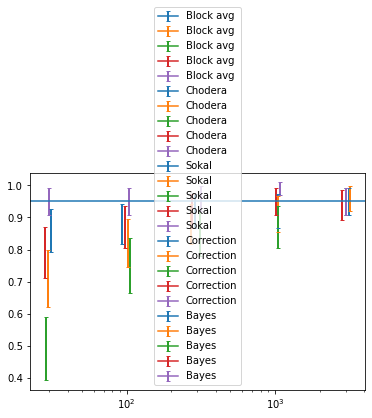

In [34]:
my_results = list()
for res in [bavg_results, chodera_results, sokal_results,
            correction_results, bayes_results]:
    ci_95 = 1.96*res
    print(((ci_95-np.abs(estimated_means))>0).sum(0))
    my_results.append(((ci_95-np.abs(estimated_means))>0).sum(0))
    
    
z=1.96
for col, datasize, label in zip(range(6), [30, 100, 300,1000,3000], ['Block avg', 'Chodera' ,'Sokal', 'Correction', 'Bayes']):
    for color, item in enumerate(np.array(my_results)[:,col]):
        it = item/100
        confint = z* np.sqrt((it*(1-it))/100)
        plt.errorbar(datasize+np.random.uniform(-datasize*0.1, datasize*0.1), 
                     it, mfc='white' , elinewidth=2, capsize=2,yerr=confint,c='C'+str(color), label=label)
        
plt.xscale('log')
plt.axhline(0.95)
plt.legend()

In [59]:
np.random.uniform(-0.1, 0.1, len(datasizes))

array([ 0.00987476, -0.03704028, -0.09737911, -0.06560206, -0.06717733])

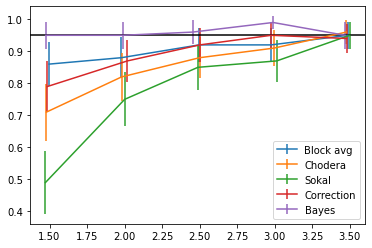

In [65]:
items = np.array(my_results)/100
confint = z*((items*(1-items))/100)**0.5
datasizes = [30, 100, 300,1000,3000]
for b, lab, ci in zip(items, ['Block avg', 'Chodera' ,'Sokal', 'Correction', 'Bayes'], confint):
    plt.errorbar(np.log10(datasizes)+np.random.uniform(-0.025, 0.025, len(datasizes)),  
                 b, yerr=ci, label=lab)
    
#plt.xscale('log')
plt.axhline(0.95, c='k')
plt.legend()


In [51]:
ci

array([0.000931  , 0.000931  , 0.00075264, 0.00019404, 0.000931  ])

In [18]:
rpts = 1000
bavg_results2 = np.zeros([rpts,6])
chodera_results2 = np.zeros([rpts,6])
sokal_results2 = np.zeros([rpts,6])
correction_results2 = np.zeros([rpts,6])
estimated_means2 = np.zeros([rpts,6])

In [19]:
rpts = 1000
bavg_results2 = np.zeros([rpts,7])
chodera_results2 = np.zeros([rpts,7])
sokal_results2 = np.zeros([rpts,7])
correction_results2 = np.zeros([rpts,7])
estimated_means2 = np.zeros([rpts,7])
for row in tqdm.tqdm_notebook(range(rpts)):
    for col, datasize in enumerate([30, 100, 300,1000,3000]):
        cor = gen_correlated_curve(0.9, datasize)
        estimated_means2[row,col]=cor.mean()
    
        #block avg:
        s = do_block_averaging(cor)

        popt, pcov = optimize.curve_fit(block_avg_fit, np.arange(1, int(datasize**(2/3))+1), np.array(s), maxfev=25000)

            
        block_avg_sem = popt[0] *np.pi/2
        bavg_results2[row,col]=block_avg_sem

    
        #chodera, sokal:
        chodera_autoc_time = statineff(cor)
        sokal_autoc_time = sokal_autocorr_time(cor)
        n=len(cor)
        chodera_sem = np.std(cor) / np.sqrt(n/chodera_autoc_time)
        chodera_results2[row,col] = chodera_sem
        sokal_sem = np.std(cor) / np.sqrt(n/sokal_autoc_time)
        sokal_results2[row,col] = sokal_sem
    
        #correction factor:
        result = AutoReg(cor-cor.mean(), lags = [1]).fit()
        estimated_rho = result.params[1]
        correction = np.sqrt((1+estimated_rho)/(1-estimated_rho))
        naive_sem = sem(cor)
        corrected_sem = naive_sem*correction
        correction_results2[row,col]=corrected_sem
        
        

KeyboardInterrupt: 

In [192]:
cor = gen_correlated_curve(0.6, 30)
print(np.mean(cor))
#block avg:
s = do_block_averaging(cor)
popt, pcov = optimize.curve_fit(block_avg_fit, np.arange(1, int(datasize**(2/3))+1), np.array(s), maxfev=25000)
#plt.plot(s)

0.4719414507883181


ValueError: operands could not be broadcast together with shapes (464,) (9,) 

In [200]:
my_results = list()
for res in [bavg_results2, chodera_results2, sokal_results2,
            correction_results2]:
    ci_95 = 1.96*res
    print(((ci_95-np.abs(estimated_means2))>0).sum(0)/10)
    my_results.append(((ci_95-np.abs(estimated_means2))>0).sum(0)/10)
    
    
z=1.96
for col, datasize in zip(range(6), [30, 100, 300,1000,3000,10000]):
    for color, item in enumerate(np.array(my_results)[:,col]):
        it = item/100
        confint = z* np.sqrt((it*(1-it))/1000)
        plt.errorbar(datasize+np.random.uniform(-datasize*0.1, datasize*0.1), 
                     it, mfc='white' , elinewidth=2, capsize=2,yerr=confint,c='C'+str(color))
        
plt.xscale('log')
plt.axhline(0.95)

[78.  87.  91.4 95.1 94.2 94.8  0. ]
[58.2 80.9 89.4 94.8 94.5 95.1  0. ]
[39.7 70.2 83.1 93.1 93.5 94.3  0. ]
[70.6 84.9 90.4 95.3 94.5 94.7  0. ]


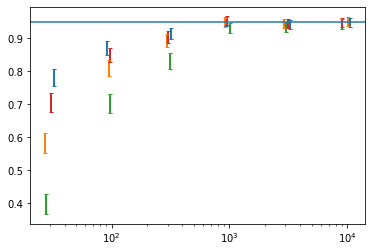

In [232]:
z=1.96
for col, datasize in zip(range(6), [30, 100, 300,1000,3000,10000]):
    for color, item in enumerate(np.array(my_results)[:,col]):
        it = item/100
        confint = z* np.sqrt((it*(1-it))/1000)
        plt.errorbar(datasize+np.random.uniform(-datasize*0.1, datasize*0.1), 
                     it, mfc='white' , elinewidth=2, capsize=2,yerr=confint,c='C'+str(color))
        
plt.xscale('log')
plt.axhline(0.95)

In [214]:
confint

0.04391056200961219

In [198]:
690000+750000-65000

1375000

See: 
*Confidence intervals in stationary autocorrelated time series*. Halkos, George and Kevork, Ilias,
at: https://mpra.ub.uni-muenchen.de/31840/1/MPRA_paper_31840.pdf , who reference:
`Fishman, G., 1978. Principles of Discrete Event Simulation. Wiley, New York.`

the below is from a cooky approach - fitting the np.log(periodogram) by linear regression to estimate the value at 0. 
`A Spectral Method for Confidence Interval Generation and Run Length Control in Simulations`

I found it in Thomson:
`A Comparison of Methods for Computing Autocorrelation Time`

In [ ]:
from scipy.signal import periodogram
#out = periodogram(correlated)
#out= welch(correlated)
peri=np.abs(np.fft.fft(correlated)**2)/len(correlated)
out = peri[:peri.shape[0]//2]
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import OLS
x_ = np.arange(len(out[1:200]))
y_ = np.log(out[1:200])

res = OLS(y_, add_constant(x_)).fit()

I = np.e**res.params[0]
print(I, I/np.var(correlated))

When you don't have enough data, the above can be a bad approximation. The full version is a bit messier:

\begin{align}
k = \sqrt{\frac{1+2\delta / n}{1 - 2\delta/(n(n-1))}}
\end{align}

where

\begin{align}
\delta = \frac{(n-1)\rho - n\rho^2 + \rho^{n+1}}{(1-\rho)^2}
\end{align}